# Advanced Lane finding using OpenCV

# Import Libraries

In [1]:
# import libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pickle
from ipywidgets import interact, interactive, fixed
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

## Caliberating Camera

In [2]:
# Read in the image
image_lst = glob.glob("camera_cal/calibration*.jpg")

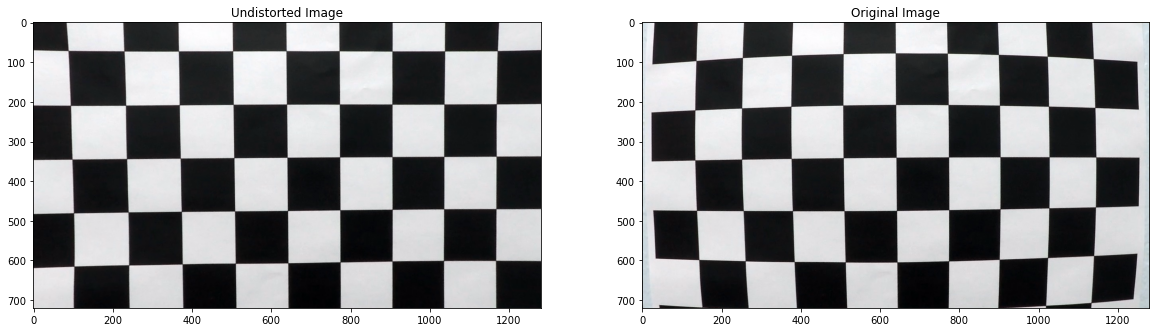

In [36]:
# Prepare the object points. These will represent the image points in real world in 3 Dimensional
objp = np.zeros((6*9, 3), np.float32)
# Selecting all rows and first 2 columns(x, y) because z will always be 0 for 2D image
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)

# Creating arrays for storing object points and image points
objpoints = []
imagepoints = []

for idx, fname in enumerate(image_lst):
    image = cv2.imread(fname)
    # Converting image to grayscale for caliberation
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Find out the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)
    if ret == True:
        objpoints.append(objp)
        imagepoints.append(corners)
        
# Camera Caliberation for above object points and image points
image = cv2.imread('camera_cal/calibration1.jpg')
img_size = [image.shape[1], image.shape[0]]
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imagepoints, img_size, None, None)
# Undistort the image
dst = cv2.undistort(image, mtx, dist, None, mtx)
f, axis = plt.subplots(1,2, figsize = (20,40))
axis[0].imshow(dst)
axis[0].set_title("Undistorted Image")
axis[1].imshow(image)
axis[1].set_title("Original Image")

# Saving pickle file of caliberation
calib_pickle = {}
calib_pickle["mtx"] = mtx
calib_pickle["dist"] = dist
pickle.dump(calib_pickle, open("caliberation.p", "wb"))

In [37]:
# Undistort an Image
def undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

## Get Birds View

In [38]:
def unwarp(img, src, dst):
    img_size = [img.shape[1], img.shape[0]]
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped, M, Minv

Text(0.5, 1.0, 'Perspective Transformed View Image')

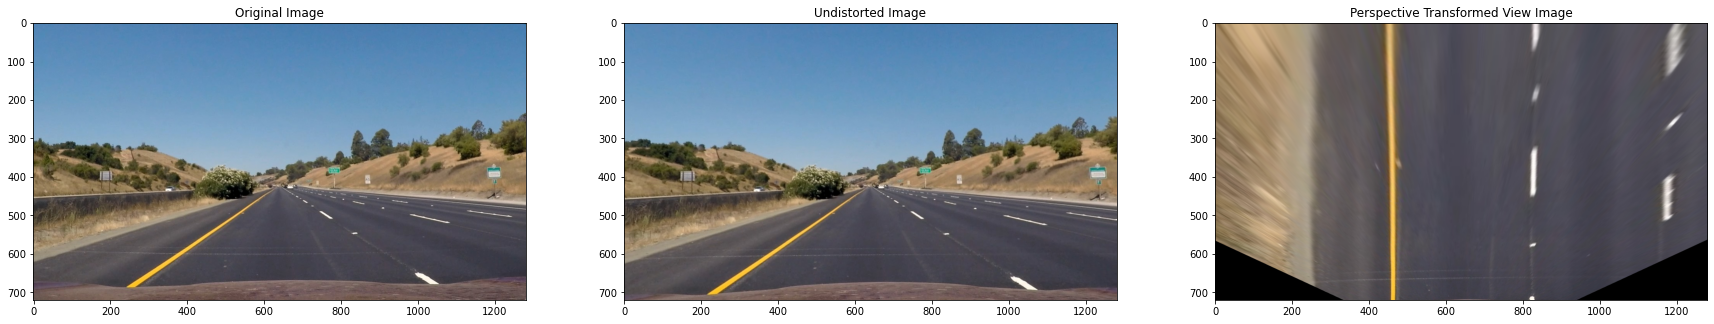

In [40]:
testImage = mpimg.imread('test_images/straight_lines1.jpg')
offset = 100
source = np.float32([(575,464),
                    (706,464), 
                    (245,676), 
                    (1051,676)])
destination = np.float32([(450,0),
                    (testImage.shape[1]-450,0),
                    (450,testImage.shape[0]),
                    (testImage.shape[1]-450,testImage.shape[0])])
undis = undistort(testImage)
unwarped, M, Minv = unwarp(undis, source, destination)
f, axis = plt.subplots(1,3, figsize = (30,90))
axis[0].imshow(testImage)
axis[0].set_title("Original Image")
axis[1].imshow(undis)
axis[1].set_title("Undistorted Image")
axis[2].imshow(unwarped)
axis[2].set_title("Perspective Transformed View Image")

## Visualize different color channels

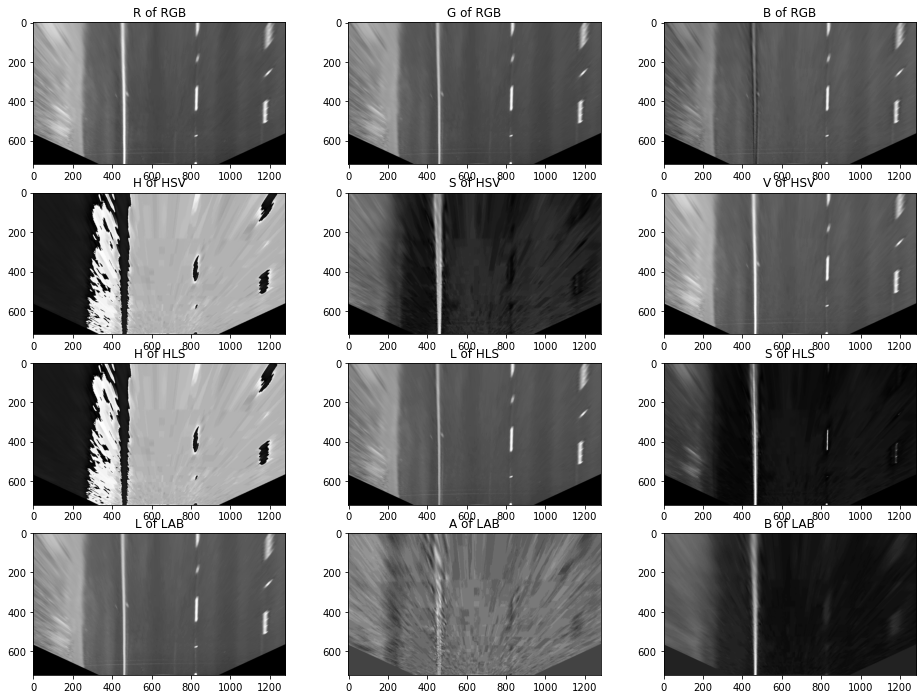

In [7]:
# Visualizing RGB color space
unwarped_R = unwarped[:, :, 0]
unwarped_G = unwarped[:, :, 1]
unwarped_B = unwarped[:, :, 2]
# Visualizing HSV color space
unwarped_hsv = cv2.cvtColor(unwarped, cv2.COLOR_RGB2HSV)
unwarped_hsv_H = unwarped_hsv[:, :, 0]
unwarped_hsv_S = unwarped_hsv[:, :, 1]
unwarped_hsv_V = unwarped_hsv[:, :, 2]
# Visualizing HLS color space
unwarped_hls = cv2.cvtColor(unwarped, cv2.COLOR_RGB2HLS)
unwarped_hls_H = unwarped_hls[:, :, 0]
unwarped_hls_L = unwarped_hls[:, :, 1]
unwarped_hls_S = unwarped_hls[:, :, 2]

# Visualizing LAB color space
unwarped_lab = cv2.cvtColor(unwarped, cv2.COLOR_RGB2LAB)
unwarped_lab_L = unwarped_lab[:, :, 0]
unwarped_lab_A = unwarped_lab[:, :, 1]
unwarped_lab_B = unwarped_lab[:, :, 2]

fig, axis = plt.subplots(4,3, figsize=(16, 12))
axis = axis.ravel()
axis[0].imshow(unwarped_R, cmap = "gray")
axis[0].set_title("R of RGB")
axis[1].imshow(unwarped_G, cmap = "gray")
axis[1].set_title("G of RGB")
axis[2].imshow(unwarped_B, cmap = "gray")
axis[2].set_title("B of RGB")
axis[3].imshow(unwarped_hsv_H, cmap = "gray")
axis[3].set_title("H of HSV")
axis[4].imshow(unwarped_hsv_S, cmap = "gray")
axis[4].set_title("S of HSV")
axis[5].imshow(unwarped_hsv_V, cmap = "gray")
axis[5].set_title("V of HSV")
axis[6].imshow(unwarped_hls_H, cmap = "gray")
axis[6].set_title("H of HLS")
axis[7].imshow(unwarped_hls_L, cmap = "gray")
axis[7].set_title("L of HLS")
axis[8].imshow(unwarped_hls_S, cmap = "gray")
axis[8].set_title("S of HLS")
axis[9].imshow(unwarped_lab_L, cmap = "gray")
axis[9].set_title("L of LAB")
axis[10].imshow(unwarped_lab_A, cmap = "gray")
axis[10].set_title("A of LAB")
axis[11].imshow(unwarped_lab_B, cmap = "gray")
axis[11].set_title("B of LAB")
fig.show()

## Define Abs Sobel Threshold

In [41]:
def sobel_Threshold(img, orient = 'x', thresh = (25,255)):
    # Convert the image to gray scale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # calculate Sobel according to orientation
    if orient == 'x':
        sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    else:
        sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Scaling on 8 bit scale
    scaled_sobel = np.uint8(255*(sobel/np.max(sobel)))
    # Creating Mask
    binary_mask = np.zeros_like(scaled_sobel)
    binary_mask[(scaled_sobel >= thresh[0]) & (scaled_sobel < thresh[1])] = 1
    return binary_mask

Text(0.5, 1.0, 'Sobel Warped Image')

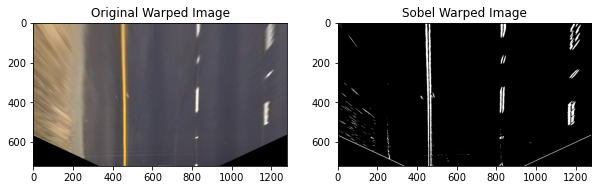

In [42]:
f, axis = plt.subplots(1,2, figsize = (10, 20))
axis[0].imshow(unwarped)
axis[0].set_title("Original Warped Image")
axis[1].imshow(sobel_Threshold(unwarped, 'x', (15,255)), cmap = "gray")
axis[1].set_title("Sobel Warped Image")

## Define Sobel Threshold with Magnitude

In [43]:
def mag_Sobel_Threshold(img, sobel_kernal = 23, thresh = (25, 255)):
    # Convert image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Calculate Sobel x and Sobel y
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernal)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernal)
    # Calculate magnitude
    sobelmag = np.sqrt(sobelx**2 + sobely**2)
    # Scale to 8 bit
    scaled_sobel = np.uint8(255*sobelmag/np.max(sobelmag))
    binary_mask = np.zeros_like(scaled_sobel)
    binary_mask[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_mask

Text(0.5, 1.0, 'Sobel with Magnitude Warped Image')

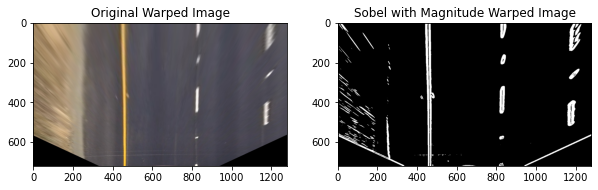

In [44]:
f, axis = plt.subplots(1,2, figsize = (10, 20))
axis[0].imshow(unwarped)
axis[0].set_title("Original Warped Image")
axis[1].imshow(mag_Sobel_Threshold(unwarped, 17, (23,200)), cmap = "gray")
axis[1].set_title("Sobel with Magnitude Warped Image")

## Define Sobel Threshold with Direction

In [12]:
def dir_Sobel_Threshold(img, sobel_kernal = 7, thresh = (0, 0.09)):
    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Calculate Sobel x and Sobel y
    sobelx = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernal))
    sobely = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernal))
    # Calculate direction of gradient
    grad_dir = np.arctan2(sobely, sobelx)
    binary_mask = np.zeros_like(grad_dir)
    binary_mask[(grad_dir >= thresh[0]) & (grad_dir <= thresh[1])] = 1
    return binary_mask

Text(0.5, 1.0, 'Sobel with Direction of Magnitude Warped Image')

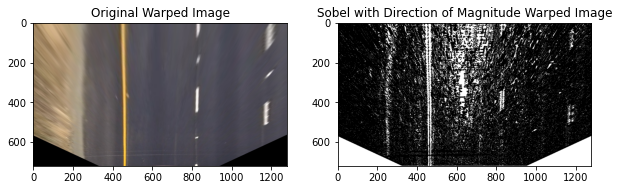

In [45]:
f, axis = plt.subplots(1,2, figsize = (10, 20))
axis[0].imshow(unwarped)
axis[0].set_title("Original Warped Image")
axis[1].imshow(dir_Sobel_Threshold(unwarped), cmap = "gray")
axis[1].set_title("Sobel with Direction of Magnitude Warped Image")

Interact is the function which is used to set and get the required threshold values

In [14]:
def update(kernel_size, min_thresh, max_thresh):
    exampleImg_sobelDir = dir_Sobel_Threshold(unwarped, 13, (0.01, 0.06))
    # Visualize sobel direction threshold
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    f.subplots_adjust(hspace = .2, wspace=.05)
    ax1.imshow(unwarped, cmap='gray')
    ax1.set_title('Original Image')
    ax2.imshow(exampleImg_sobelDir, cmap='gray')
    ax2.set_title('Sobel Direction of Magnitude')
interact(update, kernel_size=(1,25,2), 
                 min_thresh=(0,np.pi/2,0.01),
                max_thresh=(0,np.pi/2,0.01))

interactive(children=(IntSlider(value=13, description='kernel_size', max=25, min=1, step=2), FloatSlider(value…

<function __main__.update(kernel_size, min_thresh, max_thresh)>

In [46]:
def update(mag_kernel_size, mag_min_thresh, mag_max_thresh, dir_kernel_size, dir_min_thresh, dir_max_thresh):
    exampleImg_sobelMag2 = mag_Sobel_Threshold(unwarped, mag_kernel_size, (mag_min_thresh, mag_max_thresh))
    exampleImg_sobelDir2 = dir_Sobel_Threshold(unwarped, dir_kernel_size, (dir_min_thresh, dir_max_thresh))
    combined = np.zeros_like(exampleImg_sobelMag2)
    combined[((exampleImg_sobelMag2 == 1) & (exampleImg_sobelDir2 == 1))] = 1
    # Visualize sobel magnitude + direction threshold
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    f.subplots_adjust(hspace = .2, wspace=.05)
    ax1.imshow(unwarped)
    ax1.set_title('Unwarped Image', fontsize=30)
    ax2.imshow(combined, cmap='gray')
    ax2.set_title('Sobel Magnitude + Direction', fontsize=30)

interact(update, mag_kernel_size=(1,31,2), 
                 mag_min_thresh=(0,255), 
                 mag_max_thresh=(0,255),
                 dir_kernel_size=(1,31,2), 
                 dir_min_thresh=(0,np.pi/2,0.01), 
                 dir_max_thresh=(0,np.pi/2,0.01))

interactive(children=(IntSlider(value=15, description='mag_kernel_size', max=31, min=1, step=2), IntSlider(val…

<function __main__.update(mag_kernel_size, mag_min_thresh, mag_max_thresh, dir_kernel_size, dir_min_thresh, dir_max_thresh)>

## Defining L and S of HLS Color Space

In [47]:
def l_colorspace_HLS(img, thresh = (220, 255)):
    # Convert BGR to HLS colorspace
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    hls = hls[:, :, 1]
    hls = hls*(255/np.max(hls))
    binary_mask = np.zeros_like(hls)
    binary_mask[(hls >= thresh[0]) & (hls < thresh[1])] = 1
    return binary_mask

def s_colorspace_HLS(img, thresh = (125, 255)):
    # Convert BGR to HLS colorspace
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    hls = hls[:, :, 2]
    binary_mask = np.zeros_like(hls)
    binary_mask[(hls >= thresh[0]) & (hls < thresh[1])] = 1
    return binary_mask

In [48]:
def b_colorspace_LAB(img, thresh = (190, 255)):
    # Convert BGR to HLS colorspace
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    lab = lab[:,:,2]
    if np.max(lab) > 175:
        lab = lab*(255/np.max(lab))
    binary_mask = np.zeros_like(lab)
    binary_mask[(lab >= thresh[0]) & (lab <= thresh[1])] = 1
    return binary_mask

In [49]:
def update(l_thresh_min, l_thresh_max, s_thresh_min, s_thresh_max):
    l_unwarped_HLS = l_colorspace_HLS(unwarped, (l_thresh_min, l_thresh_max))
    s_unwarped_HLS = s_colorspace_HLS(unwarped, (s_thresh_min, s_thresh_max))
    combine_mask = np.zeros_like(s_unwarped_HLS)
    combine_mask[((s_unwarped_HLS == 1) | (l_unwarped_HLS == 1))] = 1
    # Visualize sobel magnitude + direction threshold
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    f.subplots_adjust(hspace = .2, wspace=.05)
    ax1.imshow(unwarped)
    ax1.set_title('Unwarped Image', fontsize=30)
    ax2.imshow(combine_mask, cmap='gray')
    ax2.set_title('L and S Combines of HLS', fontsize=30)

interact(update, l_thresh_min=(0,255), l_thresh_max=(0,255), s_thresh_min=(0,255), s_thresh_max=(0,255))




interactive(children=(IntSlider(value=127, description='l_thresh_min', max=255), IntSlider(value=127, descript…

<function __main__.update(l_thresh_min, l_thresh_max, s_thresh_min, s_thresh_max)>

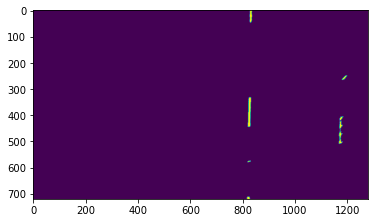

In [50]:
l_unwarped_HLS = l_colorspace_HLS(unwarped)
plt.imshow(l_unwarped_HLS)

In [55]:
def pipeline(img):
    
    # Load mtx and distortion coeficient from pickle
    
    # Image Size
    h,w = img.shape[:2]

    # define source and destination points for transform
    src = np.float32([(575,464),
                  (707,464), 
                  (258,682), 
                  (1049,682)])
    dst = np.float32([(450,0),
                  (w-450,0),
                  (450,h),
                  (w-450,h)])
    
    # Undistort the image using caliberation
    undist = undistort(img)
    
    # Perspective transform to get the bird's eye view
    unwarped, M, Minv = unwarp(undist, src, dst)
    
    # Get Sobel Magnitude of threshold
    mag_sobel = mag_Sobel_Threshold(unwarped)
    
    # Get Sobel Direction of magnitude
    dir_sobel = dir_Sobel_Threshold(unwarped)
    
    # Get L channel from HLS color space
    l_hlsImage = l_colorspace_HLS(unwarped)
    
    # Get B channel from LAB color space
    b_labImage = b_colorspace_LAB(unwarped)
    
    # Getting lot of noise in result under shaded area so will check with other color space
    # Get S channel form HLS color space
    #s_hlsImage = s_colorspace_HLS(unwarped)
    
    # Combine result of all operations
    combine_mask = np.zeros_like(dir_sobel)
    #combine_mask[((l_hlsImage == 1) | (s_hlsImage == 1)) | ((mag_sobel == 1) & (dir_sobel == 1))] = 1
    #combine_mask[((l_hlsImage == 1) | (b_labImage == 1)) | ((mag_sobel == 1) & (dir_sobel == 1))] = 1
    #combine_mask[((mag_sobel == 1) & (dir_sobel == 1))] = 1
    
    combine_mask[((l_hlsImage == 1) | (b_labImage == 1))] = 1
    plt.imshow(combine_mask, cmap="gray")
    
    return combine_mask, Minv

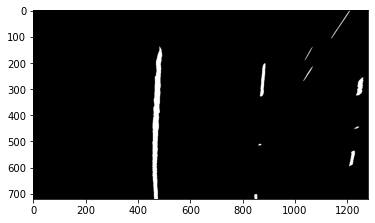

In [56]:
combine, Minv = pipeline(mpimg.imread("test_images/test1.jpg"))
#plt.imshow(combine, cmap="gray")

## Sliding Window Polyfit

In [78]:
def fit_poly(img):
    # The input image will be a binary image from our previous pipeline
    # Draw Histogram to calculate the left and right lane
    histogram = np.sum(img[img.shape[0]//2:, :], axis = 0)
    
    # Finding the peak of left and right lane
    midpoint = np.int(histogram.shape[0]//2)
    # We have seen the camera is caliberated at thew center so the left and right lanes will surelt be in the middle quaters
    quater_point = np.int(midpoint//2)
    # Calculate left lane and right lane center point
    leftx_base = np.argmax(histogram[quater_point:midpoint]) + quater_point
    rightx_base = np.argmax(histogram[midpoint:(midpoint+quater_point)]) + midpoint
    # Total number of sliding windows
    nwindows = 10
    window_height = np.int(img.shape[0]//nwindows)
    # Identify the nonzero pixels and their x and y cordinates
    nonzero = img.nonzero()
    nonzerox = nonzero[1]
    nonzeroy = nonzero[0]
    # Current position for to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set width of window +- margin
    margin = 100
    minpix = 40
    # Create empty list to receive left and right lane pixels indices
    left_lane_inds = []
    right_lane_inds = []
    # Rectangle data for visualization
    rectangle_data = []
    
    # Step through each window in the nwindows
    for window in range(nwindows):
        # Extract pixel coordinates of rectangle in each lane. These cordinated are of top left and bottom right corners
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        rectangle_data.append((win_y_low, win_y_high, win_xleft_low, win_xleft_high, win_xright_low, win_xright_high))
        
        # Identy the non zero pixels within the window frames in left and right lane
        good_left_ind = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_ind = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to our list
        left_lane_inds.append(good_left_ind)
        right_lane_inds.append(good_right_ind)
        
        # Check if we have number of nonzero pixels greater than the minimum pixels
        if len(good_left_ind) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_ind]))
        if len(good_right_ind) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_ind]))
        
    # Concatenate array of indices.
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right lane pixel cordinates
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fit, right_fit = (None, None)
    
    if(len(leftx) != 0):
        left_fit = np.polyfit(lefty, leftx, 2)
    if(len(rightx) != 0):
        right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds, rectangle_data, histogram

(720.0, 0.0)

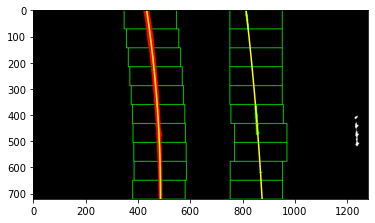

In [79]:
testImage = mpimg.imread("test_images/test2.jpg")
h, w = testImage[0], testImage[1]
binary_mask, Minv = pipeline(testImage)
left_fit, right_fit, left_lane_inds, right_lane_inds, rectangle_data, histogram = fit_poly(binary_mask)

left_fit_x_int = left_fit[0]*(h**2) + left_fit[1]*h + left_fit[2]
right_fit_x_int = right_fit[0]*(h**2) + right_fit[1]*h + right_fit[2]

# Output image to plot rectangles and highlight left and right lane
out_img = np.uint8(np.dstack((binary_mask, binary_mask, binary_mask))*255)

ploty = np.linspace(0, binary_mask.shape[0] - 1, binary_mask.shape[0])
left_fit_x = left_fit[0] * (ploty**2) + left_fit[1]*ploty + left_fit[2]
right_fit_x = right_fit[0] * (ploty**2) + right_fit[1]*ploty + right_fit[2]

# Draw windows on lanes
for rect in rectangle_data:
    cv2.rectangle(out_img,(rect[2],rect[0]),(rect[3],rect[1]),(0,255,0), 2) 
    cv2.rectangle(out_img,(rect[4],rect[0]),(rect[5],rect[1]),(0,255,0), 2) 

# Non Zero pixels in Binary Image
nonzero = binary_mask.nonzero()
nonzerox = nonzero[1]
nonzeroy = nonzero[0]

# Highlighting left and right lanes with red and blue color
out_img[ nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[ nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 255, 0]

plt.imshow(out_img)
plt.plot(left_fit_x, ploty, color = "yellow")
plt.plot(right_fit_x, ploty, color = "yellow")
plt.xlim(0, 1280)
plt.ylim(720, 0)

## Polyfit using previous frame

In [84]:
def fit_poly_previousframe(binary_warped, left_fit_prev, right_fit_prev):
    # Non Zero pixels in Binary Image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    # getting good indexes in left lane and right lane
    left_lane_inds = ((nonzerox > (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] - margin)) & 
                      (nonzerox < (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] - margin)) & 
                       (nonzerox < (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] + margin)))  

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fit_new, right_fit_new = (None, None)
    if len(leftx) != 0:
        # Fit a second order polynomial to each
        left_fit_new = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit_new = np.polyfit(righty, rightx, 2)
    return left_fit_new, right_fit_new, left_lane_inds, right_lane_inds

(720.0, 0.0)

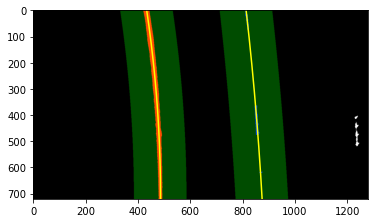

In [90]:
margin = 100

# Left fit and right fit values are taken from previous function output
left_fit2, right_fit2, left_lane_inds2, right_lane_inds2 = fit_poly_previousframe(binary_mask, left_fit, right_fit)

# Retrive cordinates to plot
ploty = np.linspace(0, binary_mask.shape[0]-1, binary_mask.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
left_fitx2 = left_fit2[0]*ploty**2 + left_fit2[1]*ploty + left_fit2[2]
right_fitx2 = right_fit2[0]*ploty**2 + right_fit2[1]*ploty + right_fit2[2]

# Output image to plot rectangles and highlight left and right lane
out_img = np.uint8(np.dstack((binary_mask, binary_mask, binary_mask))*255)
window_img = np.zeros_like(out_img)

# Non Zero pixels in Binary Image
nonzero = binary_mask.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

# Highlighting left and right lanes with red and blue color
out_img[nonzeroy[left_lane_inds2], nonzerox[left_lane_inds2]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds2], nonzerox[right_lane_inds2]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the left and right lane
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx2, ploty, color='yellow')
plt.plot(right_fitx2, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

## Calculate Radius of Curvature

In [86]:
def measure_curvature_real(img, left_fit, right_fit, left_lane_inds, right_lane_inds):
    # meters per pixel in y dimension, as per given information lane line is 10 ft = 3.048 meters
    ym_per_pix = 3.048/100
    # meters per pixel in x dimension, as per given information lane width is 12 ft = 3.7 meters
    xm_per_pix = 3.7/378
    left_curverad, right_curverad, center_dist = (0, 0, 0)
    # Define y-value where we want radius of curvature. Here I have chosen y_eval the value nearest to our car which is bottom of the image
    h = img.shape[0]
    ploty = np.linspace(0, h-1, h)
    y_eval = np.max(ploty)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Extract left and right line pixel cordinates
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    if len(leftx) != 0 and len(rightx) != 0:
        # Fit new polynomials to x,y in world space. Here we have first conversted thge scale to real world and then found the polynomial equation of degree 2
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        # Now our radius of curvature is in meters
    
    # Distance from center is image x midpoint - mean of left_fit and right_fit intercepts 
    if right_fit is not None and left_fit is not None:
        car_position = img.shape[1]/2
        left_fit_x_int = left_fit[0]*h**2 + left_fit[1]*h + left_fit[2]
        right_fit_x_int = right_fit[0]*h**2 + right_fit[1]*h + right_fit[2]
        lane_center_position = (right_fit_x_int + left_fit_x_int) /2
        center_dist = (car_position - lane_center_position) * xm_per_pix
    return left_curverad, right_curverad, center_dist

In [87]:
left_curverad, right_curverad, center_dist = measure_curvature_real(binary_mask, left_fit, right_fit, left_lane_inds, right_lane_inds)

print(left_curverad, 'm,', right_curverad, 'm')
print(center_dist, 'm')

454.4923661402174 m, 1194.672938565744 m
-0.39640812917076096 m


In [88]:
def final(original_img, binary_img, left_fit, right_fit, Minv):
    if left_fit is None or right_fit is None:
        return original_img
    # Create an image to draw the lines on
    mask = np.zeros_like(binary_img).astype(np.uint8)
    out_img = np.dstack((mask, mask, mask))
    
    h,w = binary_img.shape
    ploty = np.linspace(0, h-1, num=h)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(out_img, np.int_([pts]), (0,255, 0))
    cv2.polylines(out_img, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(out_img, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(out_img, Minv, (w, h)) 
    # Combine the result with the original image
    result = cv2.addWeighted(original_img, 1, newwarp, 0.5, 0)
    return result

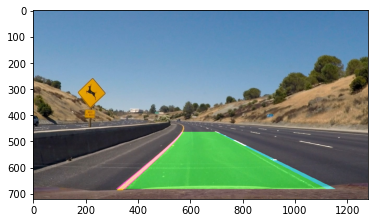

In [89]:
result = final(testImage, binary_mask, left_fit, right_fit, Minv)
plt.imshow(result)

In [69]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #number of detected pixels
        self.px_count = None
    def add(self, fit, inds):
        # add a found fit to the line, up to n
        if fit is not None:
            if self.best_fit is not None:
                # if we have a best fit, see how this new fit compares
                self.diffs = abs(fit-self.best_fit)
            if (self.diffs[0] > 0.001 or \
               self.diffs[1] > 1.0 or \
               self.diffs[2] > 100.) and \
               len(self.current_fit) > 0:
                self.detected = False
            else:
                self.detected = True
                self.px_count = np.count_nonzero(inds)
                self.current_fit.append(fit)
                if len(self.current_fit) > 5:
                    # throw out old fits, keep newest n
                    self.current_fit = self.current_fit[len(self.current_fit)-5:]
                self.best_fit = np.average(self.current_fit, axis=0)
        # or remove one from the history, if not found
        else:
            self.detected = False
            if len(self.current_fit) > 0:
                # throw out oldest fit
                self.current_fit = self.current_fit[:len(self.current_fit)-1]
            if len(self.current_fit) > 0:
                # if there are still any fits in the queue, best_fit is their average
                self.best_fit = np.average(self.current_fit, axis=0)



In [70]:
def main(img):
    img_bin, Minv = pipeline(img)
    
    # if both left and right lines were detected in the last frame, use fit_poly_previousframe, otherwise use fit_poly for sliding window for the first frame
    if not l_line.detected or not r_line.detected:
        left_fit, right_fit, left_lane_inds, right_lane_inds, rectangle_data, histogram = fit_poly(img_bin)
    else:
        left_fit, right_fit, left_lane_inds, right_lane_inds = fit_poly_previousframe(img_bin, l_line.best_fit, r_line.best_fit)
        
    # validating if both fit's difference in their x-intercepts is around 350 px +- 100 px
    if left_fit is not None and right_fit is not None:
        # calculate x-intercept for both fits near to car
        h = img.shape[0]
        left_fit_x_int = left_fit[0]*h**2 + left_fit[1]*h + left_fit[2]
        right_fit_x_int = right_fit[0]*h**2 + right_fit[1]*h + right_fit[2]
        x_int_diff = abs(right_fit_x_int-left_fit_x_int)
        if abs(350 - x_int_diff) > 100:
            left_fit = None
            right_fit = None
            
    l_line.add(left_fit, left_lane_inds)
    r_line.add(right_fit, right_lane_inds)
    
    # draw the current best fit if it exists
    if l_line.best_fit is not None and r_line.best_fit is not None:
        img_out1 = final(img, img_bin, l_line.best_fit, r_line.best_fit, Minv)
        rad_left, rad_right, d_center = measure_curvature_real(img_bin, l_line.best_fit, r_line.best_fit, 
                                                               left_lane_inds, right_lane_inds)
        print(rad_left, rad_right, d_center)
        img_out = img_out1
    else:
        # This will draw the original image
        img_out = img
    return img_out

t:   0%|          | 0/1199 [00:00<?, ?it/s, now=None]

180.2297748255708 160.64722706713312 0.6117679475881893
Moviepy - Building video harder_challenge_video_output.mp4.
Moviepy - Writing video harder_challenge_video_output.mp4



t:   0%|          | 2/1199 [00:00<01:56, 10.24it/s, now=None]

177.31203408915718 1091.7942247495782 0.534301962720574
202.0867320302676 116.84634626228545 0.5356356242933209


t:   0%|          | 5/1199 [00:00<02:48,  7.10it/s, now=None]

220.0295960699891 125.65113006174839 0.5374001095927259
215.48449878745802 170.76964373997404 0.5385912621491815


t:   1%|          | 7/1199 [00:00<02:52,  6.90it/s, now=None]

225.78658428886362 54.98087480592117 0.540092952276179
216.56360959254272 53.269246398748066 0.5415558616131547


t:   1%|          | 9/1199 [00:01<03:04,  6.45it/s, now=None]

197.3726282534635 48.714693279822406 0.5424605644018479
181.0425211165285 32.15282355701683 0.5417421034224509


t:   1%|          | 11/1199 [00:01<03:05,  6.40it/s, now=None]

149.94394203974184 33.36124043702461 0.5412722220269026
162.14730306887353 219.1704075549179 0.5396834489842455


t:   1%|          | 13/1199 [00:01<03:09,  6.25it/s, now=None]

152.71677896975353 31.147896094144564 0.5403830925273779
161.70141245274627 283.4808489022784 0.5409663740072291


t:   1%|▏         | 15/1199 [00:02<03:07,  6.33it/s, now=None]

166.22369281462332 101.11021761561534 0.5436746543925866
148.1921018828667 56.84323593218187 0.5469186046269712


t:   1%|▏         | 17/1199 [00:02<03:06,  6.33it/s, now=None]

135.5421974773185 41.76199710823176 0.5524237000339473
146.6852772250484 94.21250820917574 0.5541799816033502


t:   2%|▏         | 19/1199 [00:02<03:23,  5.81it/s, now=None]

124.35604026071836 56.183423322685165 0.5571597379329694
128.9151574672392 87.80935554570105 0.5586079950893365


t:   2%|▏         | 20/1199 [00:03<03:28,  5.65it/s, now=None]

98.99675674709592 54.44361847369109 0.5614640279494654
94.89656337977608 189.44754986857674 0.5634641961262408


t:   2%|▏         | 23/1199 [00:03<03:43,  5.25it/s, now=None]

80.06422367635665 72.09183795590906 0.5704032784645579
74.21999687595368 165.31075336006316 0.5793480985300458


t:   2%|▏         | 24/1199 [00:03<03:45,  5.21it/s, now=None]

68.07660789051688 60.308060144695894 0.5922729234544319
73.37525743811044 147.16299799480265 0.6026832379387657


t:   2%|▏         | 26/1199 [00:04<04:08,  4.72it/s, now=None]

61.21344668410334 51.53400279085709 0.6182655828263041


t:   2%|▏         | 27/1199 [00:04<04:19,  4.51it/s, now=None]

56.55922465801718 51.668494135329 0.6334793819473155
62.26505636533441 95.65209794999589 0.6436431260259425

t:   2%|▏         | 28/1199 [00:04<04:14,  4.60it/s, now=None]

t:   2%|▏         | 29/1199 [00:05<04:29,  4.34it/s, now=None]

53.42511561609192 47.95765778036496 0.6555217930379825


t:   3%|▎         | 30/1199 [00:05<04:35,  4.25it/s, now=None]

55.17599094993642 47.431405222029674 0.6661170475718597


t:   3%|▎         | 31/1199 [00:05<04:29,  4.34it/s, now=None]

57.98513957167838 67.78655170350288 0.6628427886892606


t:   3%|▎         | 32/1199 [00:05<04:37,  4.21it/s, now=None]

45.169338667130916 41.211687003207494 0.6736359783859995


t:   3%|▎         | 33/1199 [00:06<04:42,  4.12it/s, now=None]

44.385286232229625 41.99612566928838 0.7408277051628164


t:   3%|▎         | 34/1199 [00:06<04:43,  4.11it/s, now=None]

44.79928452406651 41.3931900416033 0.7347014511114573


t:   3%|▎         | 35/1199 [00:06<04:39,  4.17it/s, now=None]

43.9206651958707 43.00495456544813 0.7349674828553058


t:   3%|▎         | 36/1199 [00:06<04:38,  4.18it/s, now=None]

44.5715223863615 51.58146659630182 0.7267705753663423


t:   3%|▎         | 37/1199 [00:07<04:43,  4.10it/s, now=None]

36.04930502132388 43.76252436222741 0.7267705753663423


t:   3%|▎         | 38/1199 [00:07<05:06,  3.79it/s, now=None]

33.810015376473444 446.8533409585807 0.7267705753663423


t:   3%|▎         | 39/1199 [00:07<05:23,  3.59it/s, now=None]

32.7067601893069 559.4129220105996 0.7267705753663423


t:   3%|▎         | 40/1199 [00:07<05:28,  3.52it/s, now=None]

34.48609380790961 459.6013549009427 0.7267705753663423


t:   3%|▎         | 41/1199 [00:08<05:29,  3.52it/s, now=None]

36.571077481228805 473.2292497368818 0.7267705753663423


t:   4%|▎         | 42/1199 [00:08<05:11,  3.72it/s, now=None]

31.078015900833524 115.03102954293213 0.7267705753663423


t:   4%|▎         | 43/1199 [00:08<05:13,  3.69it/s, now=None]

31.911095345069864 124.66420087362029 0.7267705753663423


t:   4%|▎         | 44/1199 [00:09<05:19,  3.62it/s, now=None]

43.12170797871186 376.40789677253923 0.7267705753663423


t:   4%|▍         | 45/1199 [00:09<05:42,  3.37it/s, now=None]

43.18185628355504 717.8682232983263 0.7267705753663423


t:   4%|▍         | 46/1199 [00:09<05:40,  3.38it/s, now=None]

45.452073214805445 206.16523891060942 0.7267705753663423


t:   4%|▍         | 48/1199 [00:10<04:43,  4.06it/s, now=None]

43.86093072661284 390.90297848183627 0.7267705753663423
21.27451886952423 65.21894784394696 0.7267705753663423


t:   4%|▍         | 49/1199 [00:10<05:07,  3.75it/s, now=None]

45.05383902816672 391.13271825226565 0.7267705753663423


t:   4%|▍         | 50/1199 [00:10<05:34,  3.43it/s, now=None]

38.254869960432025 627.4024371115025 0.7267705753663423


t:   4%|▍         | 51/1199 [00:11<05:44,  3.33it/s, now=None]

40.887212584683994 448.3270214143413 0.7267705753663423


t:   4%|▍         | 52/1199 [00:11<05:46,  3.31it/s, now=None]

49.72172570417215 286.96963992645027 0.7267705753663423


t:   4%|▍         | 53/1199 [00:11<06:02,  3.16it/s, now=None]

43.494574716289655 542.8746518696568 0.7267705753663423


t:   5%|▍         | 54/1199 [00:12<06:09,  3.10it/s, now=None]

44.39923672919875 456.5865553844069 0.7267705753663423


t:   5%|▍         | 55/1199 [00:12<06:11,  3.08it/s, now=None]

47.59738809694261 467.01012512662174 0.7267705753663423


t:   5%|▍         | 56/1199 [00:12<06:09,  3.10it/s, now=None]

53.509368925020325 415.8933963180763 0.7267705753663423


t:   5%|▍         | 57/1199 [00:13<06:09,  3.09it/s, now=None]

70.84485666826293 342.13888810342763 0.7267705753663423


t:   5%|▍         | 58/1199 [00:13<06:03,  3.14it/s, now=None]

85.12452938001871 365.2868262665616 0.7267705753663423


t:   5%|▍         | 59/1199 [00:13<05:52,  3.24it/s, now=None]

108.13040987098748 100.78540321036616 0.7267705753663423


t:   5%|▌         | 60/1199 [00:13<05:43,  3.31it/s, now=None]

84.1145870031074 548.5457398746125 0.7267705753663423


t:   5%|▌         | 62/1199 [00:14<05:00,  3.79it/s, now=None]

90.65636701827351 957.7784337190277 0.7267705753663423
76.50976376915341 546.861918085357 0.7267705753663423


t:   5%|▌         | 64/1199 [00:14<04:15,  4.44it/s, now=None]

98.90934115179486 4354.172325835608 0.7267705753663423
129.78256625363798 74.74991569945136 -0.6712564572820321


t:   6%|▌         | 66/1199 [00:15<03:34,  5.29it/s, now=None]

32.50708300612952 67.86806414925387 -0.6712564572820321
964.6897055952999 39.40924129828623 -0.3652612661408808


t:   6%|▌         | 68/1199 [00:15<02:50,  6.63it/s, now=None]

235.1783740123698 36.03139596425218 -0.41611687726898355
180.27885642643727 34.91835534211615 -0.46294332340455074


t:   6%|▌         | 70/1199 [00:15<02:36,  7.24it/s, now=None]

159.69908740943978 37.2675437864743 -0.4909069181696744
136.84905353317538 37.55617404633426 -0.5277171197836525


t:   6%|▌         | 72/1199 [00:15<02:25,  7.74it/s, now=None]

107.50555249586871 37.893256941903424 -0.5977700576273973
92.74658005689412 35.84710863396864 -0.6585589906454915


t:   6%|▌         | 74/1199 [00:16<02:22,  7.91it/s, now=None]

88.27291229847472 38.30206750629741 -0.7046077562948801
83.56983737968321 36.35650955084674 -0.7440589351790491


t:   6%|▋         | 76/1199 [00:16<02:22,  7.88it/s, now=None]

75.07968669561254 31.38412285459475 -0.7628063432116902
78.21235050074756 343.33642486397173 -0.7765466856760047


t:   7%|▋         | 78/1199 [00:16<02:43,  6.87it/s, now=None]

414.30485012553004 29.519543274904546 -0.7765466856760047
53.91664603760985 20.355958004146167 -0.7706870741704469


t:   7%|▋         | 80/1199 [00:17<03:03,  6.09it/s, now=None]

58.342608198397954 21.57484611808821 -0.7525045982490047
59.48434847458159 105.48490950843197 -0.7525045982490047


t:   7%|▋         | 82/1199 [00:17<02:49,  6.59it/s, now=None]

61.26971140427035 468.81524571071566 -0.7525045982490047
60.082158850409755 37.40220286615424 -0.694117889911662


t:   7%|▋         | 84/1199 [00:17<02:42,  6.88it/s, now=None]

70.82409041348859 38.084982127621835 -0.7081139755129421
73.93319492479769 42.70827587548217 -0.7081139755129421


t:   7%|▋         | 86/1199 [00:17<02:38,  7.02it/s, now=None]

79.08225881259406 36.89966560448667 -0.7081139755129421
88.08463207654314 38.85592144370384 -0.7081139755129421


t:   7%|▋         | 88/1199 [00:18<02:35,  7.12it/s, now=None]

96.41892285161411 107.16595570276885 -0.7081139755129421
114.79261248118269 224.60820442380006 -0.7081139755129421


t:   8%|▊         | 90/1199 [00:18<02:34,  7.16it/s, now=None]

21.01070744579587 5728.861306234176 -0.7081139755129421
45.964486150011986 103.06123422597292 -0.6888944358600212


t:   8%|▊         | 92/1199 [00:18<02:32,  7.28it/s, now=None]

46.26406951282554 39.66462411400303 -0.7411074182267017
244.89185405315175 103.78907227631206 -0.7411074182267017


t:   8%|▊         | 94/1199 [00:18<02:30,  7.33it/s, now=None]

279.29293235647845 88.95337134050519 -0.7411074182267017
2293.608845784541 74.41435697708548 -0.7411074182267017


t:   8%|▊         | 96/1199 [00:19<02:30,  7.35it/s, now=None]

145.7531418427608 74.31846958364706 -0.7411074182267017
61.16130945919135 27.61160994620647 -0.7411074182267017


t:   8%|▊         | 98/1199 [00:19<02:31,  7.29it/s, now=None]

44.9571208397345 70.52588219115897 -0.7411074182267017
55.72995613207581 65.70443932579826 -0.7411074182267017


t:   8%|▊         | 100/1199 [00:19<02:29,  7.37it/s, now=None]

83.92978074455478 61.07493426577707 -0.7411074182267017
134.0159238995436 56.85392620523655 -0.7411074182267017


t:   9%|▊         | 102/1199 [00:20<02:30,  7.29it/s, now=None]

179.40761349426975 52.093855219062824 -0.7411074182267017
363.2987575767918 58.24491061971853 -0.7262025505962736


t:   9%|▊         | 104/1199 [00:20<02:31,  7.23it/s, now=None]

860.6266990412962 53.659811791748886 -0.717953056449293
957.704426375066 45.954726972735656 -0.717953056449293


t:   9%|▉         | 106/1199 [00:20<02:23,  7.61it/s, now=None]

516.5676564792426 44.40238816462726 -0.38803917054905523
308.1596490289334 42.60753543342861 -0.38914237691105946


t:   9%|▉         | 108/1199 [00:20<02:19,  7.81it/s, now=None]

229.7608307721911 41.26797869225653 -0.38617967427991734
172.69789108006555 39.181161081784076 -0.39555729832341674


t:   9%|▉         | 110/1199 [00:21<02:16,  8.00it/s, now=None]

179.00195288957866 37.676438833933254 -0.3817244935772463
153.07070377232054 36.69439129715581 -0.36361910415259713


t:   9%|▉         | 112/1199 [00:21<02:17,  7.90it/s, now=None]

203.00965858755202 34.970379372484956 -0.3581029029897582
89.24599973998309 42.70122984017336 -0.38020572381675194


t:  10%|▉         | 114/1199 [00:21<02:27,  7.34it/s, now=None]

101.53999864615837 28.852711495490748 -0.39850711949073003
91.96478428127723 28.225123491029432 -0.39850711949073003


t:  10%|▉         | 116/1199 [00:21<02:26,  7.38it/s, now=None]

134.8627919466591 27.532539061884286 -0.39850711949073003
153.5092520240443 27.370623691252973 -0.39850711949073003


t:  10%|▉         | 118/1199 [00:22<02:26,  7.37it/s, now=None]

100.67131375385216 27.127945442127558 -0.39850711949073003
87.13711626062151 27.515672859309536 -0.39850711949073003


t:  10%|█         | 120/1199 [00:22<02:22,  7.55it/s, now=None]

81.93205269232425 27.349935926942994 -0.39850711949073003
83.86288242388093 26.992928797011345 -0.39850711949073003


t:  10%|█         | 122/1199 [00:22<02:19,  7.75it/s, now=None]

79.27880794039642 26.45155545101847 -0.39850711949073003
64.79782598722247 25.885939656082222 -0.39850711949073003


t:  10%|█         | 124/1199 [00:22<02:18,  7.74it/s, now=None]

62.482521659528125 25.10047054796521 -0.39850711949073003
65.17129629274346 24.450636710550736 -0.39850711949073003


t:  11%|█         | 126/1199 [00:23<02:19,  7.71it/s, now=None]

55.42446362302827 23.99485242199109 -0.39850711949073003
44.77620051419578 23.93211101299894 -0.39850711949073003


t:  11%|█         | 128/1199 [00:23<02:30,  7.12it/s, now=None]

43.864903757617505 25.368352301925853 -0.3930777987633377
44.27812405054062 25.728508815669223 -0.3930777987633377


t:  11%|█         | 130/1199 [00:23<02:24,  7.39it/s, now=None]

49.23569591539224 24.29310898782156 -0.3930777987633377
43.13105441281801 22.724624505687128 -0.3930777987633377


t:  11%|█         | 132/1199 [00:24<02:22,  7.51it/s, now=None]

46.544801215624716 24.80839531603843 -0.3930777987633377
43.73605422346937 24.812857016119075 -0.3930777987633377


t:  11%|█         | 134/1199 [00:24<02:21,  7.51it/s, now=None]

42.31512420175841 22.633706935405648 -0.3930777987633377
42.885217235745635 25.211808188098566 -0.3930777987633377


t:  11%|█▏        | 136/1199 [00:24<02:19,  7.64it/s, now=None]

41.67711028242573 25.046851543778377 -0.3930777987633377
41.19751780988019 25.598576493772402 -0.3930777987633377


t:  12%|█▏        | 138/1199 [00:24<02:21,  7.50it/s, now=None]

41.75326717743225 22.04335536950415 -0.3930777987633377
42.291455058309765 26.91377868546427 -0.3930777987633377


t:  12%|█▏        | 140/1199 [00:25<02:23,  7.40it/s, now=None]

43.08680072585313 27.72911736748991 -0.3930777987633377
44.18338163191934 27.525935676834642 -0.3930777987633377


t:  12%|█▏        | 142/1199 [00:25<02:21,  7.45it/s, now=None]

45.614210386351964 25.98556757507516 -0.3930777987633377
42.2437268320293 29.83374781756946 -0.3930777987633377


t:  12%|█▏        | 144/1199 [00:25<02:19,  7.54it/s, now=None]

46.50008158228395 30.469662842639327 -0.3930777987633377
45.85454313528143 30.847465484511194 -0.3930777987633377


t:  12%|█▏        | 146/1199 [00:25<02:19,  7.57it/s, now=None]

48.85846071286448 31.67086719121531 -0.3930777987633377
57.35249702066122 22.477082229562868 -0.3930777987633377


t:  12%|█▏        | 148/1199 [00:26<02:21,  7.41it/s, now=None]

59.38184020430019 29.561519400653868 -0.3930777987633377
58.11931437017956 35.78810656639842 -0.3930777987633377


t:  13%|█▎        | 150/1199 [00:26<02:20,  7.46it/s, now=None]

63.72182955482917 106.49137330421466 -0.39555687221178387
65.15035785014105 98.89648932549517 -0.39555687221178387


t:  13%|█▎        | 152/1199 [00:26<02:25,  7.20it/s, now=None]

63.58106453147422 97.54982178531635 -0.39555687221178387
73.40559341970794 133.17600363304112 -0.39555687221178387


t:  13%|█▎        | 154/1199 [00:26<02:23,  7.26it/s, now=None]

76.08156807274563 107.42366149658376 -0.39555687221178387
71.41262513612648 119.93744506361163 -0.39555687221178387


t:  13%|█▎        | 156/1199 [00:27<02:20,  7.42it/s, now=None]

81.52362657300984 162.771070772935 -0.39555687221178387
82.09915840483833 170.07918218634046 -0.39555687221178387


t:  13%|█▎        | 158/1199 [00:27<02:20,  7.42it/s, now=None]

81.7172893219405 136.8244440914331 -0.39555687221178387
78.97932171938497 108.10068491794269 -0.39555687221178387


t:  13%|█▎        | 160/1199 [00:27<02:20,  7.40it/s, now=None]

80.39433908803902 203.30153688695756 -0.39555687221178387
72.42036104318218 232.2400398370572 -0.39555687221178387


t:  14%|█▎        | 162/1199 [00:28<02:17,  7.54it/s, now=None]

72.62146967521744 107.97548533333698 -0.39555687221178387
74.59504476446887 113.18997495995305 -0.39555687221178387


t:  14%|█▎        | 164/1199 [00:28<02:11,  7.87it/s, now=None]

69.37265887912164 96.01844822604522 -0.39555687221178387
73.09352682404841 107.5808247585173 -0.39555687221178387


t:  14%|█▍        | 166/1199 [00:28<02:12,  7.78it/s, now=None]

72.03514236076214 146.54844309509065 -0.39555687221178387
78.61182733019561 132.21019645962963 -0.39555687221178387


t:  14%|█▍        | 168/1199 [00:28<02:07,  8.06it/s, now=None]

82.40322432880889 160.06812202358736 -0.39555687221178387
78.64578290994328 96.49183663132085 -0.39555687221178387


t:  14%|█▍        | 170/1199 [00:29<02:05,  8.20it/s, now=None]

74.32934441874531 58.72005685567614 -0.39555687221178387
88.61312328824563 112.27250826422555 -0.39555687221178387


t:  14%|█▍        | 172/1199 [00:29<02:06,  8.14it/s, now=None]

89.9054405814092 101.26209045091606 -0.39555687221178387
85.82467306800719 76.7238526308099 -0.39555687221178387


t:  15%|█▍        | 174/1199 [00:29<02:08,  8.00it/s, now=None]

86.08912497199375 106.50456951398623 -0.39555687221178387
85.78109429069107 169.0444230000663 -0.26015072955680557


t:  15%|█▍        | 176/1199 [00:29<02:01,  8.43it/s, now=None]

82.94851840611719 139.13214718928248 -0.26593210776136805
80.75979904580564 47.3248065670397 -0.2709540919795749


t:  15%|█▍        | 178/1199 [00:29<02:01,  8.38it/s, now=None]

70.87506094780004 48.27934263348013 -0.27546048426567854
66.32194488664483 106.16629633071176 -0.32643798028369525


t:  15%|█▌        | 180/1199 [00:30<01:59,  8.53it/s, now=None]

59.40636012734445 19.881114241947405 -0.3352314166598474
62.84765986338449 156.44437621774392 -0.34202613073716365


t:  15%|█▌        | 182/1199 [00:30<01:58,  8.56it/s, now=None]

65.81477006641806 191.82689309408457 -0.29228162284210174
125.03088861577676 138.35098275793652 -0.29228162284210174


t:  15%|█▌        | 184/1199 [00:30<01:58,  8.54it/s, now=None]

63.93939620917998 64.73114289458844 -0.288336193310278
69.94532725725257 93.26115386534646 -0.28498886076999125


t:  16%|█▌        | 186/1199 [00:30<02:00,  8.40it/s, now=None]

74.90037755204115 47.87063017760995 -0.2809980604159906
80.4022674858377 41.21165923778331 -0.2809980604159906


t:  16%|█▌        | 188/1199 [00:31<02:06,  8.00it/s, now=None]

351.56268669077804 135.33250502041813 -0.2809980604159906
435.4718551141179 356.7761913108003 -0.2809980604159906


t:  16%|█▌        | 190/1199 [00:31<02:00,  8.35it/s, now=None]

0 0 -0.2551679532955467
0 0 -0.2551679532955467


t:  16%|█▌        | 192/1199 [00:31<01:56,  8.61it/s, now=None]

0 0 -0.2551679532955467
0 0 -0.2551679532955467


t:  16%|█▌        | 194/1199 [00:31<02:24,  6.95it/s, now=None]

1446.7062896514174 98.77844056361977 -0.2551679532955467
102.72779034321987 101.88939567478283 -0.2551679532955467


t:  16%|█▋        | 196/1199 [00:32<02:21,  7.09it/s, now=None]

0 0 64.97671771100819
141.23000107513715 141.23000107513715 64.97671771100819


t:  17%|█▋        | 198/1199 [00:32<02:24,  6.90it/s, now=None]

195.20946002571418 178.80020381629052 64.97671771100819
163.68546279997096 116.9121821715798 64.97671771100819


t:  17%|█▋        | 200/1199 [00:32<02:28,  6.72it/s, now=None]

102.96652522761936 84.47876493100051 64.97671771100819
73.23238629924403 45.34608447158824 64.97671771100819


t:  17%|█▋        | 202/1199 [00:33<02:42,  6.15it/s, now=None]

57.255262366632124 43.57982085526825 64.97671771100819
50.41685802323494 45.83726598570296 64.97671771100819


t:  17%|█▋        | 204/1199 [00:33<02:49,  5.85it/s, now=None]

40.585545252851084 63.223208976432936 64.97671771100819
37.303079206398834 75.81649691404442 64.97671771100819


t:  17%|█▋        | 205/1199 [00:33<02:59,  5.54it/s, now=None]

37.05795343025525 45.29858858370873 64.97671771100819


t:  17%|█▋        | 207/1199 [00:34<03:11,  5.17it/s, now=None]

50.36140859806489 50.68211725558443 64.97671771100819
76.5266935697977 47.712780684016856 -0.26828972063232126


t:  17%|█▋        | 209/1199 [00:34<02:43,  6.05it/s, now=None]

40.523637025619216 44.732651156299546 -0.26826865083537754
24.681817550338845 81.19122500314072 -0.26828972063232126


t:  18%|█▊        | 211/1199 [00:34<02:30,  6.57it/s, now=None]

23.821987465787554 87.01686064631811 -0.26828972063232126
22.964482777304237 56.548267259460964 -0.24945095238588716


t:  18%|█▊        | 213/1199 [00:34<02:16,  7.22it/s, now=None]

21.776620490577333 35.83577642762276 -0.2548224847152586
20.886149720738704 65.25922748517672 -0.2500450675375039


t:  18%|█▊        | 214/1199 [00:35<03:19,  4.93it/s, now=None]

126.38242770589827 163.55901557995202 -0.24945095238588716


t:  18%|█▊        | 215/1199 [00:35<04:10,  3.93it/s, now=None]

121.41154708054596 191.17425903848465 -0.24945095238588716


t:  18%|█▊        | 216/1199 [00:36<04:43,  3.47it/s, now=None]

115.35822886084965 220.69902292559223 -0.24945095238588716


t:  18%|█▊        | 217/1199 [00:36<05:07,  3.19it/s, now=None]

107.83764026021665 403.85029675943264 -0.24945095238588716


t:  18%|█▊        | 218/1199 [00:36<05:24,  3.03it/s, now=None]

97.399277751026 1558.9624275534056 -0.24945095238588716


t:  18%|█▊        | 219/1199 [00:37<05:40,  2.88it/s, now=None]

95.30969961956696 288.5605339047167 -0.24945095238588716


t:  18%|█▊        | 220/1199 [00:37<05:46,  2.83it/s, now=None]

76.38900805879915 54.35745269206284 -0.24945095238588716


t:  18%|█▊        | 221/1199 [00:37<05:51,  2.79it/s, now=None]

82.66104180166518 94.11715893017289 -0.24945095238588716


t:  19%|█▊        | 223/1199 [00:38<04:52,  3.34it/s, now=None]

78.988543832382 144.03811350573287 -0.8905309504189588
68.95204997641794 172.74217287358601 -0.8774432669367984


t:  19%|█▉        | 225/1199 [00:38<03:22,  4.80it/s, now=None]

66.29402259976918 192.05711114819474 -0.8640745921448809
52.22700762140217 46.00721201858518 -0.8640745921448809


t:  19%|█▉        | 226/1199 [00:38<02:58,  5.44it/s, now=None]

46.21321291757721 115.30850905645609 -0.8774432669367984


t:  19%|█▉        | 228/1199 [00:39<03:28,  4.65it/s, now=None]

62.533671929348586 295.01513594507077 -0.8026263035089125
66.22783957269229 240.58563742636406 -0.7855140007409089


t:  19%|█▉        | 230/1199 [00:39<02:45,  5.86it/s, now=None]

68.7523121740653 198.90486229229575 -0.776818440732109
82.50941676301137 361.6870665830388 -0.7270964949846883


t:  19%|█▉        | 231/1199 [00:39<02:30,  6.44it/s, now=None]

76.43589931613234 70.79766714409163 -0.7373974649776269


t:  19%|█▉        | 232/1199 [00:39<02:47,  5.79it/s, now=None]

71.01397266794515 56.17060257137044 -0.7684554020781688


t:  20%|█▉        | 234/1199 [00:40<02:55,  5.49it/s, now=None]

68.87120483717419 52.888544691245045 -0.7494679583981169
75.69590668592976 40.563190178378555 -0.7513697378562784


t:  20%|█▉        | 236/1199 [00:40<02:43,  5.88it/s, now=None]

89.1806858280714 39.282073188755305 -0.8850650993213371
40.873473988625165 110.29812944594889 -0.8850650993213371


t:  20%|█▉        | 238/1199 [00:41<02:54,  5.51it/s, now=None]

47.022219833337275 61.814915029731864 -0.4247365378467456
49.00395642615912 84.33924354770427 -0.38353706958310463


t:  20%|██        | 240/1199 [00:41<02:23,  6.66it/s, now=None]

49.59443635949679 60.24239132721198 -0.38574551423064796
54.48323657743531 76.90822773746588 -0.37014620751096317


t:  20%|██        | 242/1199 [00:41<02:25,  6.58it/s, now=None]

55.86475778511225 60.70843300443713 -0.37042617895710633
57.52916762776993 256.86375660714344 -0.3705685812207161


t:  20%|██        | 244/1199 [00:41<02:35,  6.15it/s, now=None]

60.71853692725648 326.5689068725849 -0.3698171374717994
64.53753391810312 69.75189958571379 -0.3693653523983058


t:  20%|██        | 245/1199 [00:42<03:07,  5.10it/s, now=None]

69.83865673244661 331.0592717114756 -0.38698508567161605


t:  21%|██        | 246/1199 [00:42<03:13,  4.92it/s, now=None]

72.47030207417666 34.9735205383231 -0.3862908196399566


t:  21%|██        | 248/1199 [00:42<03:11,  4.97it/s, now=None]

75.66491813164295 33.905647227125435 -0.38497654475380844
80.67947063852641 31.32040328659441 -0.38456591970427034


t:  21%|██        | 249/1199 [00:43<03:03,  5.18it/s, now=None]

79.67358907125606 29.030524392540322 -0.3840734520276923


t:  21%|██        | 251/1199 [00:43<03:10,  4.97it/s, now=None]

83.42554390930474 272.90983079353936 -0.3820419045149655
79.11795566357537 293.59890121937553 -0.38137907547773325


t:  21%|██        | 253/1199 [00:43<02:42,  5.83it/s, now=None]

87.79414038583937 230.2081194694948 -0.3818209521214028
83.89622025619921 665.0506149663437 -0.38144609847908745


t:  21%|██▏       | 255/1199 [00:44<02:50,  5.55it/s, now=None]

88.87046059327706 154.67336003169711 -0.4240909082607559
90.23523261860586 44.44884932869305 -0.4237738380213616


t:  21%|██▏       | 256/1199 [00:44<03:07,  5.04it/s, now=None]

102.60520404495985 48.16199967217285 -0.42523378907121306


t:  21%|██▏       | 257/1199 [00:44<03:16,  4.79it/s, now=None]

95.96195824195858 34.86336140018936 -0.42422014049401874


t:  22%|██▏       | 259/1199 [00:44<03:12,  4.89it/s, now=None]

84.35068759855378 31.63500726254793 -0.42422014049401874
83.24578056881823 30.989296450949418 -0.42422014049401874


t:  22%|██▏       | 261/1199 [00:45<03:06,  5.03it/s, now=None]

88.23420647822536 29.547107842631885 -0.42422014049401874
89.18518943129551 24.157624338128436 -0.42422014049401874


t:  22%|██▏       | 263/1199 [00:45<02:46,  5.61it/s, now=None]

44.25092741838678 21.019021485688448 -0.42422014049401874
40.47248527199749 32.8544068105339 -0.3945119172862133


t:  22%|██▏       | 265/1199 [00:45<02:28,  6.31it/s, now=None]

36.9134482078892 22.576565048116173 -0.3903683616514596
114.41690793284043 34.853680042807575 -0.3451499654851654


t:  22%|██▏       | 267/1199 [00:46<02:16,  6.80it/s, now=None]

115.44797630510158 23.691900006952544 -0.3451499654851654
114.61756323468093 21.968500772411804 -0.3451499654851654


t:  22%|██▏       | 268/1199 [00:46<02:10,  7.15it/s, now=None]

122.99692326898318 21.863019664368323 -0.3451499654851654


t:  23%|██▎       | 270/1199 [00:46<02:18,  6.71it/s, now=None]

104.5596104088467 78.16531166825862 -0.3451499654851654
106.25382204092162 57.83086052708725 -0.3451499654851654


t:  23%|██▎       | 272/1199 [00:46<02:15,  6.85it/s, now=None]

111.14581715680524 267.9955510622311 -0.3451499654851654
89.43631926469142 75.26279863408017 -0.3451499654851654


t:  23%|██▎       | 274/1199 [00:47<02:09,  7.15it/s, now=None]

87.21329700858041 6.124427155199063 -0.3451499654851654
70.69097085056113 40.32967832240048 -0.3451499654851654


t:  23%|██▎       | 276/1199 [00:47<02:13,  6.93it/s, now=None]

35.130387992804735 33.6626566930112 -0.3451499654851654
25.35684947557952 29.105452329737176 -0.3451499654851654


t:  23%|██▎       | 278/1199 [00:47<02:24,  6.38it/s, now=None]

36.018416546077276 335.40747683329244 -0.3451499654851654
164.75977692993828 97.81464930986733 -0.3451499654851654


t:  23%|██▎       | 280/1199 [00:48<02:06,  7.28it/s, now=None]

93.09152753157971 90.45491477803556 -0.3451499654851654
164.75977692993828 57.38274048620888 -0.3451499654851654


t:  24%|██▎       | 282/1199 [00:48<01:55,  7.92it/s, now=None]

164.75977692993828 38.638865177362455 -0.3451499654851654
164.75977692993828 37.943428703721466 -0.3451499654851654


t:  24%|██▎       | 284/1199 [00:48<01:52,  8.11it/s, now=None]

164.75977692993828 38.88936062423191 -0.3451499654851654
164.75977692993828 43.28449819777134 -0.3451499654851654


t:  24%|██▍       | 286/1199 [00:48<01:51,  8.16it/s, now=None]

164.93974455418999 44.07501153048053 -0.3451499654851654
164.93974455418999 46.70164593864231 -0.3451499654851654


t:  24%|██▍       | 288/1199 [00:49<01:52,  8.08it/s, now=None]

219.8005590290329 64.6840914609923 -0.3451499654851654
0 0 -0.3492935211199191


t:  24%|██▍       | 290/1199 [00:49<02:24,  6.27it/s, now=None]

1776.7180368464988 83.52987100709313 -0.3492935211199191
169.46106703657114 20.097355193758588 -0.3492935211199191


t:  24%|██▍       | 292/1199 [00:49<02:15,  6.68it/s, now=None]

151.34670877272487 12.370871873335705 -0.3492935211199191
200.96235763400156 11.129870546390663 -0.3492935211199191


t:  25%|██▍       | 294/1199 [00:50<02:07,  7.08it/s, now=None]

219.2007254059553 10.073105928246054 -0.3492935211199191
6452.05434094555 117.91564758839694 -0.3492935211199191


t:  25%|██▍       | 296/1199 [00:50<02:02,  7.37it/s, now=None]

1200.4890815012354 76.45687452907379 -0.3492935211199191
540.1957402898163 83.93445955555862 -0.3492935211199191


t:  25%|██▍       | 298/1199 [00:50<02:21,  6.37it/s, now=None]

1133.0858166127766 159.25350812195293 -0.3492935211199191
1033.0206423066682 77.82054605858555 -0.3492935211199191


t:  25%|██▌       | 300/1199 [00:50<02:20,  6.41it/s, now=None]

2416.028354703334 76.990124381981 -0.3492935211199191
1559.6504379323371 1756.468493016214 -0.3492935211199191


t:  25%|██▌       | 302/1199 [00:51<02:13,  6.72it/s, now=None]

460.7906427405761 65.84848512666746 -0.3492935211199191
461.73377177129606 14.841436743489567 -0.3492935211199191


t:  25%|██▌       | 304/1199 [00:51<02:07,  7.02it/s, now=None]

345.2918246150548 75.25104212266156 -0.3492935211199191
685.3299895823709 27.49693745534751 -0.3492935211199191


t:  26%|██▌       | 306/1199 [00:51<02:06,  7.07it/s, now=None]

534.2803093922392 27.485643572080942 -0.3492935211199191
721.9046847412576 15.461836208517028 -0.3492935211199191


t:  26%|██▌       | 308/1199 [00:52<02:01,  7.35it/s, now=None]

654.2140621773532 14.573364373082601 -0.3492935211199191
506.8974619563686 43.13390353934328 -0.3492935211199191


t:  26%|██▌       | 310/1199 [00:52<01:54,  7.80it/s, now=None]

544.6958589484584 62.41117297139129 -0.3492935211199191
400.4045117605317 39.88489383212493 -0.3492935211199191


t:  26%|██▌       | 312/1199 [00:52<01:52,  7.91it/s, now=None]

81.76706365756314 37.65963148226054 -0.3492935211199191
294.6848565216328 41.20906887712495 -0.3492935211199191


t:  26%|██▌       | 314/1199 [00:52<01:49,  8.06it/s, now=None]

289.6491647064176 45.134682300090525 -0.3492935211199191
40.30204428291922 5.590890944773195 -0.3945119172862133


t:  26%|██▋       | 316/1199 [00:53<01:49,  8.06it/s, now=None]

56.15879246012807 4.744522006835039 -0.6484972204410021
364.3652624292844 53.207652356581214 -0.6484972204410021


t:  27%|██▋       | 318/1199 [00:53<01:51,  7.90it/s, now=None]

100.74102840096059 46.391611842590116 -0.6484972204410021
79.15583786985823 50.90309870672361 -0.6484972204410021


t:  27%|██▋       | 320/1199 [00:53<02:05,  6.98it/s, now=None]

145.28321987353468 202.58506247393697 -0.6484972204410021
132.122573021799 174.35174312857583 -0.6484972204410021


t:  27%|██▋       | 322/1199 [00:53<02:11,  6.69it/s, now=None]

122.44251428248887 217.15794309813612 -0.6484972204410021
81.86522583410107 1790.6660288188332 -0.6484972204410021


t:  27%|██▋       | 324/1199 [00:54<02:15,  6.46it/s, now=None]

100.79387449061421 118.10947974383231 -0.6484972204410021
93.35570412581804 76.12548416349475 -0.6484972204410021


t:  27%|██▋       | 326/1199 [00:54<02:18,  6.30it/s, now=None]

113.3800384968189 97.08036913339264 -0.6484972204410021
128.61518843740208 93.22706262786242 -0.6484972204410021


t:  27%|██▋       | 328/1199 [00:54<02:19,  6.25it/s, now=None]

130.57544701119133 76.89820428137702 -0.6484972204410021
75.95887210920593 39.72595887778345 -0.6484972204410021


t:  28%|██▊       | 330/1199 [00:55<02:20,  6.18it/s, now=None]

309.45712377873366 31.90635309511665 -0.6484972204410021
4774.737358691347 233.06784145587008 -0.45514488042649387


t:  28%|██▊       | 332/1199 [00:55<02:13,  6.48it/s, now=None]

526.9520614472473 94.74225970698966 -0.5062420537514646
150.6734777681126 122.41750858156894 -0.48497737969807136


t:  28%|██▊       | 334/1199 [00:55<02:19,  6.21it/s, now=None]

92.76328552307153 150.6495753747984 -0.46954277560167745
182.65585972247158 152.9734242739858 -0.46612488992201


t:  28%|██▊       | 336/1199 [00:56<02:10,  6.63it/s, now=None]

64.92523609252362 104.19500453227204 -0.43029074968093634
50.04952420426171 39.788337826180125 -0.46886989229588905


t:  28%|██▊       | 338/1199 [00:56<02:24,  5.97it/s, now=None]

329.8975884383531 1507.7531944972993 -0.47434207399340494
191.84550145626775 390.1808239215932 -0.49989362933386006


t:  28%|██▊       | 340/1199 [00:56<02:31,  5.68it/s, now=None]

69.2980167651175 75.75515521009736 -0.5573392270764375
173.16757089932204 234.74961427291572 -0.5573392270764375


t:  29%|██▊       | 342/1199 [00:57<02:38,  5.41it/s, now=None]

163.71647224710838 135.4768306368176 -0.5573392270764375
57.276703494576644 61.764923676339876 -0.5573392270764375


t:  29%|██▊       | 344/1199 [00:57<02:38,  5.40it/s, now=None]

79.63678371763403 59.82716311394902 -0.5573392270764375
58.28029211478738 37.858287229367455 -0.5573392270764375


t:  29%|██▉       | 346/1199 [00:57<02:33,  5.57it/s, now=None]

22.451102345417006 289.0363487844693 -0.5573392270764375
20.505158730974255 281.319748329287 -0.5573392270764375


t:  29%|██▉       | 348/1199 [00:58<02:24,  5.87it/s, now=None]

19.86741466032523 149.09045463231107 -0.5573392270764375
18.452996065478903 118.2832047880478 -0.5573392270764375


t:  29%|██▉       | 350/1199 [00:58<02:22,  5.97it/s, now=None]

25.760698553728982 111.34949611301688 -0.5573392270764375
19.160033221957192 13.156911435461168 -0.5573392270764375


t:  29%|██▉       | 352/1199 [00:58<02:19,  6.05it/s, now=None]

11.667073913948235 94.44492817249339 -0.5573392270764375
17.159325675775868 9.680315341984315 -0.5573392270764375


t:  30%|██▉       | 354/1199 [00:59<02:17,  6.16it/s, now=None]

70.44245758725766 45.79392993266445 -0.2988857229710175
28.51664858703203 45.32589482805513 -0.3268686208485859


t:  30%|██▉       | 355/1199 [00:59<02:31,  5.55it/s, now=None]

39.79218039158514 41.16506699548641 -0.31737728752690403


t:  30%|██▉       | 356/1199 [00:59<02:39,  5.28it/s, now=None]

19.040297873625008 41.0682894781438 -0.3268686208485859


t:  30%|██▉       | 358/1199 [01:00<02:31,  5.56it/s, now=None]

41.61972687843943 40.15743225608264 -0.47617605276261626
40.67676084800788 39.532549883084656 -0.4650497647285274


t:  30%|██▉       | 359/1199 [01:00<02:38,  5.30it/s, now=None]

22.859323185012947 34.819866079999095 -0.47617605276261626


t:  30%|███       | 360/1199 [01:00<02:47,  4.99it/s, now=None]

30.813083295070413 60.50934413660624 -0.820732310548477


t:  30%|███       | 361/1199 [01:00<02:55,  4.78it/s, now=None]

24.448536522214454 72.60621127697068 -0.7992707880179378


t:  30%|███       | 362/1199 [01:00<02:57,  4.72it/s, now=None]

31.12164706450804 74.477444836471 -0.7712878901403695


t:  30%|███       | 363/1199 [01:01<02:56,  4.74it/s, now=None]

44.708964430777584 274.11999119945375 -0.7712878901403695


t:  30%|███       | 365/1199 [01:01<02:51,  4.87it/s, now=None]

55.22727559278419 43.870128475932944 -0.7712878901403695
76.38093882172414 79.35770018089505 -0.7712878901403695


t:  31%|███       | 366/1199 [01:01<02:49,  4.91it/s, now=None]

31.164397866035834 25.962736704436512 -0.7712878901403695


t:  31%|███       | 367/1199 [01:01<02:53,  4.80it/s, now=None]

36.40615563839669 24.033345758796365 -0.7712878901403695


t:  31%|███       | 369/1199 [01:02<02:39,  5.22it/s, now=None]

63.303737535654825 24.666823442339016 -2.003860237710307
67.34736123418021 25.04586226933432 -2.0574227968557084


t:  31%|███       | 371/1199 [01:02<02:20,  5.91it/s, now=None]

57.975686428780605 24.698815855675388 -2.0942015327836017
59.20009858267078 25.111455711020994 -2.086082110351913


t:  31%|███       | 373/1199 [01:02<02:10,  6.34it/s, now=None]

67.21160015290934 25.577532250366072 -2.05870819727511
67.72572130806897 25.802697544920246 -2.0426871081504188


t:  31%|███▏      | 375/1199 [01:03<02:08,  6.40it/s, now=None]

84.52763097919892 26.044898255447208 -1.9747722471569846
92.78014252004408 26.54252622227275 -1.8789245065704177


t:  31%|███▏      | 377/1199 [01:03<02:05,  6.55it/s, now=None]

123.76828222947321 27.038934537180687 -1.7915914108670423
153.2947215804562 27.257673843033185 -1.712552024228099


t:  32%|███▏      | 378/1199 [01:03<02:06,  6.49it/s, now=None]

302.3658549073014 27.107719412804133 -1.7521861273418309


t:  32%|███▏      | 379/1199 [01:04<02:51,  4.77it/s, now=None]

45.453838991051455 62.67791898995525 -1.7945620482757827


t:  32%|███▏      | 380/1199 [01:04<03:26,  3.96it/s, now=None]

44.38227636103655 60.649790388262005 -1.8475829215604054


t:  32%|███▏      | 381/1199 [01:04<03:56,  3.46it/s, now=None]

43.90423160024047 58.53866891625261 -1.9237547920868607


t:  32%|███▏      | 382/1199 [01:05<04:12,  3.24it/s, now=None]

42.97860387176666 60.60253752887322 -1.9237547920868607


t:  32%|███▏      | 383/1199 [01:05<04:25,  3.07it/s, now=None]

42.51984658233754 71.03649285401076 -1.9237547920868607


t:  32%|███▏      | 384/1199 [01:05<04:37,  2.93it/s, now=None]

41.427460590915956 66.16465504500171 -1.9237547920868607


t:  32%|███▏      | 385/1199 [01:06<04:47,  2.83it/s, now=None]

40.92303928305052 65.57630094625208 -1.9237547920868607


t:  32%|███▏      | 386/1199 [01:06<04:50,  2.80it/s, now=None]

40.661973716216075 102.54002907143308 -1.9237547920868607


t:  32%|███▏      | 387/1199 [01:06<04:56,  2.74it/s, now=None]

39.573040579625534 162.81532949753387 -1.9237547920868607


t:  32%|███▏      | 388/1199 [01:07<05:02,  2.68it/s, now=None]

37.907484301056535 199.1983265731441 -1.9237547920868607


t:  32%|███▏      | 389/1199 [01:07<05:05,  2.65it/s, now=None]

37.63352264621264 210.8883144715787 -1.9237547920868607


t:  33%|███▎      | 390/1199 [01:08<05:05,  2.65it/s, now=None]

38.40320433002496 178.53441231145783 -1.9237547920868607


t:  33%|███▎      | 391/1199 [01:08<05:12,  2.59it/s, now=None]

36.25071377977408 54.69653656925621 -1.9237547920868607


t:  33%|███▎      | 392/1199 [01:08<05:19,  2.53it/s, now=None]

46.35922564900693 228.07258481623083 -1.9237547920868607


t:  33%|███▎      | 393/1199 [01:09<05:08,  2.61it/s, now=None]

31.946760516443312 26.96160099410902 -1.9237547920868607


t:  33%|███▎      | 394/1199 [01:09<05:22,  2.49it/s, now=None]

45.76695958364189 150.66025301532423 -1.9237547920868607


t:  33%|███▎      | 395/1199 [01:10<05:01,  2.67it/s, now=None]

30.300817269243936 22.89668364567849 -1.9237547920868607


t:  33%|███▎      | 396/1199 [01:10<04:43,  2.83it/s, now=None]

32.60058048241109 22.90347870599552 -1.9237547920868607


t:  33%|███▎      | 398/1199 [01:10<03:57,  3.38it/s, now=None]

76.64241978359475 106.30060548520517 -1.2119760778671722
76.16605288215604 91.83530820429938 -1.1770266163853633


t:  33%|███▎      | 400/1199 [01:11<03:00,  4.42it/s, now=None]

76.61301257067954 83.59072670565199 -1.1746858878106738
87.52454841944082 84.23704269671522 -1.139641443160642


t:  34%|███▎      | 402/1199 [01:11<02:33,  5.19it/s, now=None]

94.59575038368581 84.91178619009523 -1.1145445651767432
117.72073922141482 80.50724414633055 -1.139641443160642


t:  34%|███▎      | 403/1199 [01:11<03:14,  4.10it/s, now=None]

263.55329626993034 148.19462860895987 -1.1746858878106738


t:  34%|███▎      | 404/1199 [01:12<03:41,  3.60it/s, now=None]

63.56669473901727 176.5389653469117 -1.1770266163853633


t:  34%|███▍      | 405/1199 [01:12<04:04,  3.25it/s, now=None]

60.354735724509844 224.31832554702 -1.2119760778671722


t:  34%|███▍      | 406/1199 [01:13<04:18,  3.07it/s, now=None]

59.94651315883589 230.9863830857639 -1.2119760778671722


t:  34%|███▍      | 408/1199 [01:13<03:45,  3.51it/s, now=None]

172.803332288485 227.12227774992752 -0.9711488917263629
219.90565051971137 186.47821748767274 -0.9223847469350516


t:  34%|███▍      | 410/1199 [01:13<02:49,  4.66it/s, now=None]

296.8425988639864 193.86781258256025 -0.8893745652633999
637.4377551515936 208.88432543630614 -0.9223847469350516


t:  34%|███▍      | 411/1199 [01:14<03:02,  4.33it/s, now=None]

73.9089185385715 277.8650770382398 -0.9711488917263629


t:  34%|███▍      | 412/1199 [01:14<03:24,  3.85it/s, now=None]

76.26164360529712 350.43064472641333 -0.9711488917263629


t:  34%|███▍      | 413/1199 [01:14<03:38,  3.59it/s, now=None]

71.52414543822006 384.2303607864772 -0.9711488917263629


t:  35%|███▍      | 414/1199 [01:15<03:33,  3.68it/s, now=None]

74.18074450063216 626.805228517176 -0.9711488917263629


t:  35%|███▍      | 415/1199 [01:15<03:35,  3.64it/s, now=None]

69.2497477276139 68.32554001586719 -0.9711488917263629


t:  35%|███▍      | 416/1199 [01:15<03:38,  3.59it/s, now=None]

65.06871128435745 357.74832758873 -0.9711488917263629


t:  35%|███▍      | 417/1199 [01:15<03:42,  3.51it/s, now=None]

64.53133181881225 1077.8341513490095 -0.9711488917263629


t:  35%|███▍      | 418/1199 [01:16<03:55,  3.31it/s, now=None]

64.90777126599627 439.78206807876563 -0.9711488917263629


t:  35%|███▍      | 419/1199 [01:16<03:56,  3.30it/s, now=None]

62.30073799693206 499.09530730675465 -0.9711488917263629


t:  35%|███▌      | 420/1199 [01:16<04:02,  3.22it/s, now=None]

61.14348969568247 490.2180924333782 -0.9711488917263629


t:  35%|███▌      | 421/1199 [01:17<04:04,  3.18it/s, now=None]

59.51586156171895 534.7631934311586 -0.9711488917263629


t:  35%|███▌      | 422/1199 [01:17<04:05,  3.17it/s, now=None]

58.44606442683632 494.11288973234076 -0.9711488917263629


t:  35%|███▌      | 423/1199 [01:17<03:57,  3.27it/s, now=None]

56.54743814971335 201.20109494115903 -0.9711488917263629


t:  35%|███▌      | 424/1199 [01:18<03:37,  3.56it/s, now=None]

51.65170067428731 29.857673442629054 -0.9711488917263629


t:  35%|███▌      | 425/1199 [01:18<03:53,  3.31it/s, now=None]

53.686434551147144 436.6545397992394 -0.9711488917263629


t:  36%|███▌      | 426/1199 [01:18<04:01,  3.19it/s, now=None]

53.18171825046544 449.8100740683813 -0.9711488917263629
49.17155931269948 35.37391434203604 -0.9711488917263629


t:  36%|███▌      | 429/1199 [01:19<03:25,  3.75it/s, now=None]

47.57619882256911 458.45750017855033 -0.9711488917263629
42.47569225430765 29.90110760018494 -0.9711488917263629


t:  36%|███▌      | 430/1199 [01:19<03:38,  3.52it/s, now=None]

42.04455266769314 417.1861508844675 -0.9711488917263629


t:  36%|███▌      | 431/1199 [01:20<03:46,  3.39it/s, now=None]

40.5387660765618 452.0022393371911 -0.9711488917263629


t:  36%|███▌      | 432/1199 [01:20<03:56,  3.25it/s, now=None]

38.4608290740407 404.2981775620458 -0.9711488917263629


t:  36%|███▌      | 433/1199 [01:20<04:01,  3.17it/s, now=None]

36.63464317577734 430.51711372535766 -0.9711488917263629


t:  36%|███▌      | 434/1199 [01:21<04:10,  3.06it/s, now=None]

37.38116738640596 573.6346076590723 -0.9711488917263629


t:  36%|███▋      | 436/1199 [01:21<03:32,  3.59it/s, now=None]

34.65397689025812 489.414290374789 -0.9711488917263629
32.09115733937148 92.20741522002592 -0.9711488917263629


t:  36%|███▋      | 437/1199 [01:21<03:18,  3.84it/s, now=None]

69.02238909916608 39.33659140371439 -0.9711488917263629


t:  37%|███▋      | 438/1199 [01:22<03:14,  3.90it/s, now=None]

57.23827535645324 91.49245123006793 -0.9711488917263629


t:  37%|███▋      | 440/1199 [01:22<02:43,  4.65it/s, now=None]

54.86362475317001 95.11088380841113 -0.7011380090214723
55.25641572366495 103.82958576727 -0.7485549271401349


t:  37%|███▋      | 442/1199 [01:22<02:17,  5.50it/s, now=None]

54.94405747202338 100.51074050046053 -0.7389111252990149
54.418965666552566 110.83692795010953 -0.758164027033214


t:  37%|███▋      | 444/1199 [01:23<02:07,  5.93it/s, now=None]

52.8904850698045 115.65150627327476 -0.7606455860627961
52.19201802979146 82.87886482226398 -0.7587567892014971


t:  37%|███▋      | 446/1199 [01:23<02:03,  6.09it/s, now=None]

51.72709925566901 75.81931977200351 -0.7361660885651915
50.156921094025584 85.44114370071435 -0.7334963131010139


t:  37%|███▋      | 448/1199 [01:23<01:58,  6.33it/s, now=None]

49.33400027945642 76.99021408284761 -0.7139239756658472
48.62253401155468 80.12503431920737 -0.7043733654421939


t:  38%|███▊      | 450/1199 [01:23<01:54,  6.54it/s, now=None]

47.93628813182184 75.66825242173819 -0.7136027592309455
47.664653451052786 79.45468754140785 -0.7266273311931686


t:  38%|███▊      | 452/1199 [01:24<01:50,  6.76it/s, now=None]

47.00259345691489 84.8059943909795 -0.741008564719489
46.941650758661346 79.87751520778768 -0.7539207003399755


t:  38%|███▊      | 454/1199 [01:24<01:47,  6.91it/s, now=None]

47.04360376757136 94.10641764872622 -0.776541147437067
46.72577586445524 86.83774426174422 -0.8129904583209576


t:  38%|███▊      | 456/1199 [01:24<01:43,  7.15it/s, now=None]

46.65316296296314 81.26254498595817 -0.8490897772741659
47.29525145775557 126.65435269402975 -0.8292027724291029


t:  38%|███▊      | 458/1199 [01:25<02:01,  6.10it/s, now=None]

48.144305674089324 347.5350631094021 -0.7989078472127397
48.09644029675047 70.40264753786002 -0.780401267544946


t:  38%|███▊      | 460/1199 [01:25<02:05,  5.87it/s, now=None]

47.42037520716077 64.89496236163109 -0.7781808119274847
47.30967551088911 79.90582251611607 -0.792527067636793


t:  39%|███▊      | 462/1199 [01:25<02:04,  5.92it/s, now=None]

46.72515246436008 81.95602501273666 -0.7983422265533979
47.89049269339195 86.94684155289748 -0.7994790408958701


t:  39%|███▊      | 464/1199 [01:26<01:59,  6.13it/s, now=None]

52.14966580056613 91.49887620710633 -0.7949635291811501
175.75831393726688 96.15978309996522 -0.7949635291811501


t:  39%|███▉      | 466/1199 [01:26<01:55,  6.37it/s, now=None]

67.46649433128854 102.96681740673974 -0.7949635291811501
72.73375902938417 104.61910393074812 -0.7949635291811501


t:  39%|███▉      | 468/1199 [01:26<01:53,  6.46it/s, now=None]

75.66944498030341 108.3706162085449 -0.7949635291811501
77.45909552998725 111.76961980201747 -0.7949635291811501


t:  39%|███▉      | 470/1199 [01:27<01:53,  6.45it/s, now=None]

83.3622682706314 115.03905375158874 -0.7949635291811501
86.53672307766257 119.09125758862628 -0.7949635291811501


t:  39%|███▉      | 472/1199 [01:27<01:50,  6.56it/s, now=None]

92.31266262275352 124.29356376959237 -0.7949635291811501
96.18640222630148 129.3422242191175 -0.7949635291811501


t:  40%|███▉      | 474/1199 [01:27<01:48,  6.67it/s, now=None]

102.17819699947492 134.242961060152 -0.7949635291811501
111.97353428428356 140.28531440133776 -0.7949635291811501


t:  40%|███▉      | 476/1199 [01:28<01:49,  6.63it/s, now=None]

117.90596385742626 143.64551325883525 -0.7949635291811501
123.2728931478134 148.1013751737672 -0.7949635291811501


t:  40%|███▉      | 478/1199 [01:28<01:50,  6.54it/s, now=None]

128.38319162317185 149.37882376439646 -0.7949635291811501
128.11925558223263 157.05967382181123 -0.7949635291811501


t:  40%|████      | 480/1199 [01:28<01:53,  6.32it/s, now=None]

128.62634977438316 160.34163972549428 -0.7949635291811501
137.27248191050367 155.23562551235534 -0.7949635291811501


t:  40%|████      | 482/1199 [01:28<01:56,  6.13it/s, now=None]

144.80892689936834 161.46245942281985 -0.7949635291811501
144.92885424672366 168.51555354904607 -0.7949635291811501


t:  40%|████      | 484/1199 [01:29<02:03,  5.81it/s, now=None]

153.66164098501667 177.31865915070568 -0.7949635291811501
167.41116505233686 183.26136977817148 -0.7949635291811501


t:  41%|████      | 486/1199 [01:29<02:08,  5.56it/s, now=None]

183.43403390096864 191.59647825505667 -0.7949635291811501
204.90898548799913 205.00733595464968 -0.7949635291811501


t:  41%|████      | 488/1199 [01:30<02:11,  5.41it/s, now=None]

214.74303007961277 218.66309599837837 -0.7949635291811501
223.80229718158282 238.84385601269065 -0.7949635291811501


t:  41%|████      | 490/1199 [01:30<02:14,  5.26it/s, now=None]

253.92819556857012 262.51629890030125 -0.7949635291811501
269.9016021993291 288.7662228637417 -0.7949635291811501


t:  41%|████      | 491/1199 [01:30<02:17,  5.15it/s, now=None]

306.73240870447614 313.16113006798247 -0.7949635291811501
314.8822075990075 344.9057137581626 -0.7949635291811501


t:  41%|████      | 494/1199 [01:31<02:14,  5.24it/s, now=None]

297.37837322345246 369.65702526329824 -0.7949635291811501
291.8103392654545 378.61850898936683 -0.7949635291811501


t:  41%|████▏     | 496/1199 [01:31<02:16,  5.15it/s, now=None]

294.84125380594566 62.874576105818754 -0.7994790408958701
279.56841914830835 372.4869195638381 -0.1751309942164839


t:  42%|████▏     | 498/1199 [01:32<02:13,  5.27it/s, now=None]

276.7394345571727 512.8817304890586 -0.17399417987401183
262.0391324424826 1910.891612795504 -0.1681790209574069


t:  42%|████▏     | 499/1199 [01:32<02:12,  5.27it/s, now=None]

256.2806760421631 242.0760252689975 -0.1538327652480985


t:  42%|████▏     | 501/1199 [01:32<02:20,  4.97it/s, now=None]

251.07146939429182 66.11040400200746 -0.1538327652480985
225.97955861566547 301.253381655502 -0.1538327652480985


t:  42%|████▏     | 503/1199 [01:33<02:12,  5.26it/s, now=None]

221.59235899371333 27.47393716150042 -0.1538327652480985
218.43662424190742 370.8592200488054 -0.1538327652480985


t:  42%|████▏     | 505/1199 [01:33<02:09,  5.36it/s, now=None]

214.93096039720467 115.13239194223694 -0.1538327652480985
213.3228713233529 215.85768327080092 -0.1538327652480985


t:  42%|████▏     | 507/1199 [01:33<01:58,  5.84it/s, now=None]

218.7652235129162 181.75960043975778 0.4905672937679376
227.26563869153702 174.3245364133973 0.49538363344827785


t:  42%|████▏     | 509/1199 [01:33<01:45,  6.55it/s, now=None]

224.09042893473026 167.720244895272 0.4997580645510807
214.82347019816208 148.55493696147298 0.5050004326226374


t:  43%|████▎     | 511/1199 [01:34<01:39,  6.93it/s, now=None]

211.70036918207586 135.10850469107496 0.5092841039809327
206.32558884167767 127.20210140782295 0.5167892134887437


t:  43%|████▎     | 513/1199 [01:34<01:34,  7.22it/s, now=None]

198.58497035194165 120.54306299662996 0.5236468165914933
203.15456880728118 120.26906984654333 0.5285783598106163


t:  43%|████▎     | 515/1199 [01:34<01:33,  7.28it/s, now=None]

212.8306314581648 123.30336486829918 0.5307235511858855
211.7163543791032 123.72496926311395 0.531232720352915


t:  43%|████▎     | 517/1199 [01:35<01:32,  7.39it/s, now=None]

223.25282505336327 123.94529093378402 0.5300582696055798
240.43753999290544 126.91673293458659 0.526758424500822


t:  43%|████▎     | 519/1199 [01:35<01:30,  7.48it/s, now=None]

242.71457992392567 125.96763959144634 0.5224603278155047
249.41564880246924 126.03390613340187 0.516510675297452


t:  43%|████▎     | 521/1199 [01:35<01:31,  7.43it/s, now=None]

248.203465815248 125.66746018521044 0.509153340057847
247.94439937300177 128.08936065789467 0.5010625398138018


t:  44%|████▎     | 523/1199 [01:35<01:30,  7.48it/s, now=None]

244.72174957675566 129.27491896377694 0.49131348348139425
233.2477025302795 127.55602723568063 0.4800863757166436


t:  44%|████▍     | 525/1199 [01:36<01:31,  7.40it/s, now=None]

229.94186300365348 126.65974391652249 0.46812812329781384
208.4979998786111 126.585587714238 0.45572468640554714


t:  44%|████▍     | 527/1199 [01:36<01:30,  7.43it/s, now=None]

210.99317260275942 130.7377305396917 0.4414666056265443
194.18009347871788 137.8558648267904 0.42590683670552504


t:  44%|████▍     | 529/1199 [01:36<01:30,  7.43it/s, now=None]

193.98268461669753 146.98998213588257 0.40881673977093674
178.34772680719485 147.22654921451416 0.3945573086610131


t:  44%|████▍     | 531/1199 [01:36<01:28,  7.56it/s, now=None]

169.6472773865094 148.2591443610081 0.37993558660635385
167.18428042325849 147.95487947858192 0.36766348928594755


t:  44%|████▍     | 533/1199 [01:37<01:29,  7.47it/s, now=None]

170.4172690548932 150.5704079832339 0.35794483765128704
185.19686137918194 154.81360408483113 0.3509066002832199


t:  45%|████▍     | 535/1199 [01:37<01:27,  7.59it/s, now=None]

171.44151738313295 155.41041631897386 0.3460698245461621
203.74641007977084 185.45232064446947 0.3393431874543444


t:  45%|████▍     | 537/1199 [01:37<01:28,  7.47it/s, now=None]

212.05632399241392 200.95359679434233 0.3329088160278462
222.93003383259648 219.70678898834012 0.3265921097163928


t:  45%|████▍     | 539/1199 [01:37<01:27,  7.58it/s, now=None]

234.8060103298779 225.21754681964686 0.3205508661401184
277.52090770537086 229.44420982808055 0.3109913180254133


t:  45%|████▌     | 541/1199 [01:38<01:26,  7.58it/s, now=None]

248.0615608719162 242.22431419435114 0.3053649707213111
222.64223475844423 260.5563603448251 0.30025550591845357


t:  45%|████▌     | 543/1199 [01:38<01:25,  7.64it/s, now=None]

220.6995767212884 274.92147662532244 0.29509761588915945
223.0768694379564 303.90652326030585 0.2901999884814236


t:  45%|████▌     | 545/1199 [01:38<01:26,  7.59it/s, now=None]

213.6197097468251 328.8525075423739 0.2849573513521936
224.69369268734783 340.39696096179296 0.27913257826041593


t:  46%|████▌     | 547/1199 [01:39<01:25,  7.60it/s, now=None]

228.5642566329168 366.3178607359158 0.272425337376109
247.8650879233309 371.50232051209974 0.2651012570599987


t:  46%|████▌     | 549/1199 [01:39<01:24,  7.68it/s, now=None]

246.0284791914816 388.79787113656863 0.25703548161289586
251.78760195942675 399.8220846210063 0.24866307070467744


t:  46%|████▌     | 551/1199 [01:39<01:25,  7.61it/s, now=None]

231.86819870313042 430.6772549025831 0.24032674293879785
213.23775714156244 464.7128364101664 0.2321368809433447


t:  46%|████▌     | 553/1199 [01:39<01:25,  7.55it/s, now=None]

212.72119649253725 514.7033529152828 0.2236755792333226
176.33665065062175 548.6405443277329 0.2156042970299131


t:  46%|████▋     | 555/1199 [01:40<01:23,  7.74it/s, now=None]

141.65210735859907 614.7180920075773 0.2078233243364548
132.85254271534643 634.4002367413786 0.19993121217353121


t:  46%|████▋     | 557/1199 [01:40<01:24,  7.62it/s, now=None]

116.83092138890699 640.5264977724117 0.19200615378749905
95.79262870937613 651.8926517319316 0.18470624940923877


t:  47%|████▋     | 559/1199 [01:40<01:22,  7.78it/s, now=None]

89.5983269257476 625.5498805340092 0.17719417600195805
89.81091373426577 674.50203703541 0.16915872561198403


t:  47%|████▋     | 561/1199 [01:40<01:23,  7.67it/s, now=None]

149.07609604190785 718.390142257125 0.15888858393986013
258.6080082296022 752.9177424350244 0.15548001877597153


t:  47%|████▋     | 563/1199 [01:41<01:25,  7.48it/s, now=None]

96.23331805967057 732.6016284154244 0.14266990505747598
118.08731459183694 763.2286045800597 0.12857468593642718


t:  47%|████▋     | 565/1199 [01:41<01:23,  7.61it/s, now=None]

82.73883308506446 760.7926642888027 0.11511935451384826
160.9599447785473 760.5564490552413 0.10210210387697888


t:  47%|████▋     | 567/1199 [01:41<01:26,  7.29it/s, now=None]

29.227986659755143 803.578364406754 0.10106483398730295
85.06094738775202 769.942371235485 0.08913821814889551


t:  47%|████▋     | 569/1199 [01:41<01:23,  7.58it/s, now=None]

114.62777945713937 733.671506439648 0.07714972657720783
98.71916183668517 715.06461245251 0.06648465875991975


t:  48%|████▊     | 571/1199 [01:42<01:23,  7.52it/s, now=None]

21.044113878246947 717.4163527848391 0.06052779678126303
269.7821522801583 716.3070737004375 0.05234722378337462


t:  48%|████▊     | 573/1199 [01:42<01:23,  7.46it/s, now=None]

44.214623894084944 635.3475447804277 0.04374250409201509
123959.64665334557 578.266218652444 0.050013516326057904


t:  48%|████▊     | 575/1199 [01:42<01:22,  7.52it/s, now=None]

33.84836895708947 579.0121758114824 0.06014217238598327
604355.4806648728 507.8671035267213 0.07069470131963966


t:  48%|████▊     | 577/1199 [01:42<01:23,  7.47it/s, now=None]

0 0 0.05625987427512862
0 0 0.04545703651798302


t:  48%|████▊     | 579/1199 [01:43<01:22,  7.54it/s, now=None]

0 0 0.038422937044727046
0 0 0.024214727066498593


t:  48%|████▊     | 581/1199 [01:43<01:19,  7.75it/s, now=None]

988.377261886494 340.9347386645119 0.028023199399900833
862932.7195661124 373.8672173543781 0.03393541948263413


t:  49%|████▊     | 583/1199 [01:43<01:18,  7.81it/s, now=None]

3983.3409095528677 382.76616375870725 0.0443788676006792
529211.9969231843 458.62737498103513 0.07166791923632616


t:  49%|████▉     | 585/1199 [01:44<01:19,  7.69it/s, now=None]

3880.632435494065 452.21068917689 0.07166791923632616
748546.2877065048 597.7080240141715 0.07166791923632616


t:  49%|████▉     | 587/1199 [01:44<01:19,  7.70it/s, now=None]

6.296337827122403 708.3296313081877 0.07166791923632616
6.296337827122403 542.9627220282674 0.07166791923632616


t:  49%|████▉     | 589/1199 [01:44<01:19,  7.72it/s, now=None]

2379730.9656084212 1455.5220412388835 0.07166791923632616
318088.42234347557 473.1267631372873 0.07166791923632616


t:  49%|████▉     | 591/1199 [01:44<01:19,  7.69it/s, now=None]

2290802.4101572456 583.4128023104959 0.07166791923632616
0 0 -0.004596622381880433


t:  49%|████▉     | 593/1199 [01:45<01:15,  8.00it/s, now=None]

0 0 0.0010838657822454607
0 0 0.0010838657822454607


t:  50%|████▉     | 595/1199 [01:45<01:16,  7.93it/s, now=None]

0 0 0.0010838657822454607
5.208630244811081 14.893633315651263 -0.004596622381880433


t:  50%|████▉     | 597/1199 [01:45<01:16,  7.84it/s, now=None]

3.6939576490925763 1.8466295561619015 -0.004596622381880433
6.896743197464914 2.9341873889244683 -0.004596622381880433


t:  50%|████▉     | 599/1199 [01:45<01:16,  7.88it/s, now=None]

7320.126461986871 20.63709620375095 -0.004596622381880433
5.370242994240892 2.046311337505006 -0.004596622381880433


t:  50%|█████     | 601/1199 [01:46<01:15,  7.88it/s, now=None]

9.167477106486128 9.167477106486128 -0.004596622381880433
5638.447348862065 503611.9033146799 -0.004596622381880433


t:  50%|█████     | 603/1199 [01:46<01:13,  8.06it/s, now=None]

0 0 -0.004596622381880433
0 0 3.9140885944129393


t:  50%|█████     | 605/1199 [01:46<01:13,  8.10it/s, now=None]

0 0 3.9140885944129393
0 0 3.9140885944129393


t:  51%|█████     | 607/1199 [01:46<01:11,  8.30it/s, now=None]

0 0 3.9140885944129393
0 0 3.9140885944129393


t:  51%|█████     | 609/1199 [01:47<01:09,  8.44it/s, now=None]

0 0 3.9140885944129393
0 0 3.9140885944129393


t:  51%|█████     | 611/1199 [01:47<01:10,  8.30it/s, now=None]

0 0 0.6159736436353823
0 0 0.30559842092991524


t:  51%|█████     | 613/1199 [01:47<01:15,  7.80it/s, now=None]

0 0 0.34610479034329555
0 0 0.38056581830055836


t:  51%|█████▏    | 615/1199 [01:47<01:18,  7.40it/s, now=None]

0 0 0.32962820809156207
0 0 0.14975877374433275


t:  51%|█████▏    | 617/1199 [01:48<01:20,  7.21it/s, now=None]

0 0 0.12528921228303264
0 0 0.038958892735318044


t:  52%|█████▏    | 618/1199 [01:48<01:22,  7.01it/s, now=None]

0 0 -0.07752572873976277


t:  52%|█████▏    | 619/1199 [01:48<01:41,  5.71it/s, now=None]

181.02776014512233 355.09909372999795 -0.07228860962393831


t:  52%|█████▏    | 620/1199 [01:48<01:58,  4.90it/s, now=None]

157.28771927762085 1558.4220869545713 -0.09487345664241177


t:  52%|█████▏    | 621/1199 [01:49<02:09,  4.47it/s, now=None]

126.57891896952255 923.0655205331312 -0.0787478804225948


t:  52%|█████▏    | 622/1199 [01:49<02:17,  4.19it/s, now=None]

139.88937919349073 685.3814953259608 0.125877767255579


t:  52%|█████▏    | 623/1199 [01:49<02:22,  4.04it/s, now=None]

101.48501667477446 865.0208022993934 0.125877767255579


t:  52%|█████▏    | 624/1199 [01:49<02:26,  3.91it/s, now=None]

77.7859442456046 17370.442337894438 0.125877767255579


t:  52%|█████▏    | 626/1199 [01:50<02:08,  4.46it/s, now=None]

134.5474343269423 34.3595505552164 -0.04205047993067958
85.07376622436048 34.02347630204923 -0.05442108790614787


t:  52%|█████▏    | 628/1199 [01:50<01:44,  5.45it/s, now=None]

75.71616393722788 33.791570054514324 -0.07043237045304601
72.86720017951302 33.83574367410793 -0.09920546897337583


t:  53%|█████▎    | 630/1199 [01:50<01:31,  6.23it/s, now=None]

84.48402232524772 32.8594886999588 -0.11857600483775871
96.52572453223682 32.78818509879065 -0.1573549134913232


t:  53%|█████▎    | 632/1199 [01:51<01:26,  6.54it/s, now=None]

88.61341232395213 33.30140550494618 -0.21313143871963208
70.59064407146933 32.763130261258496 -0.2782625738740793


t:  53%|█████▎    | 634/1199 [01:51<01:23,  6.77it/s, now=None]

66.9688601831145 33.103924912352845 -0.33871686393028616
62.6311776140971 33.207263669881 -0.4071092449380522


t:  53%|█████▎    | 636/1199 [01:51<01:21,  6.87it/s, now=None]

61.19816253122061 33.02687406633952 -0.4783339309154849
59.94958767653376 33.23675785473509 -0.5350084690788498


t:  53%|█████▎    | 638/1199 [01:51<01:19,  7.06it/s, now=None]

64.08826994797109 32.87262238234993 -0.579078151003247
72.85185302810655 34.32257129282029 -0.5617329335187932


t:  53%|█████▎    | 639/1199 [01:52<01:35,  5.85it/s, now=None]

202.51972398203918 30.62525396901762 -0.5392949070783996


t:  53%|█████▎    | 640/1199 [01:52<01:51,  5.01it/s, now=None]

129.2856994101975 33.26439797384763 -0.5129081340747639


t:  53%|█████▎    | 641/1199 [01:52<02:03,  4.53it/s, now=None]

122.87079041594521 177.66225634592016 -0.4877962148154085


t:  54%|█████▎    | 642/1199 [01:52<02:07,  4.36it/s, now=None]

44.73397940113269 432.1971720214625 -0.5249559790009474


t:  54%|█████▎    | 643/1199 [01:53<02:31,  3.67it/s, now=None]

310.0770950703008 184.31407890833543 -0.4877962148154085


t:  54%|█████▍    | 645/1199 [01:53<02:08,  4.31it/s, now=None]

41.969811914437415 443.7577378213677 -0.705367329924302
35.9854517126332 193.352323655054 -0.6165353765903995


t:  54%|█████▍    | 646/1199 [01:54<02:13,  4.14it/s, now=None]

33.90334139201776 314.1920651136702 -0.6165353765903995


t:  54%|█████▍    | 647/1199 [01:54<02:17,  4.00it/s, now=None]

40.337094854459515 282.9141073528718 -0.6165353765903995


t:  54%|█████▍    | 648/1199 [01:54<02:21,  3.88it/s, now=None]

37.18093037089095 335.08873057924717 -0.6165353765903995


t:  54%|█████▍    | 649/1199 [01:54<02:45,  3.33it/s, now=None]

125.99975511213925 245.23055824967827 -0.6165353765903995


t:  54%|█████▍    | 650/1199 [01:55<03:00,  3.05it/s, now=None]

176.66531677410913 405.37255544495315 -0.6165353765903995


t:  54%|█████▍    | 652/1199 [01:55<02:38,  3.44it/s, now=None]

273.10673899936614 748.3091758373341 -0.7037357074972902
355.32750463171425 675.7841821776783 -0.6515310586989511


t:  55%|█████▍    | 654/1199 [01:56<02:01,  4.47it/s, now=None]

347.6264582088146 635.0440269838192 -0.6158017047075417
393.41885831448633 439.1044235407512 -0.587862002004251


t:  55%|█████▍    | 656/1199 [01:56<01:42,  5.29it/s, now=None]

1256.870234730873 229.21187351256887 -0.5453761137961579
329.33491793841125 225.28324202016032 -0.48336288608750283


t:  55%|█████▍    | 658/1199 [01:56<01:35,  5.67it/s, now=None]

112.4641609552184 184.1273781752448 -0.45114400493871537
2303.3515015129774 193.95283570989557 -0.4181043690412621


t:  55%|█████▌    | 660/1199 [01:57<01:31,  5.87it/s, now=None]

1829.8552388604094 183.18717143923115 -0.38970489412674364
400.14148357440723 185.21782754851043 -0.3790920633047085


t:  55%|█████▌    | 662/1199 [01:57<01:29,  6.03it/s, now=None]

474.05430393937417 176.40015906489356 -0.3664901090808675
332.33033553058414 178.00466319999137 -0.3577121146574336


t:  55%|█████▌    | 664/1199 [01:57<01:28,  6.07it/s, now=None]

145.98544387168803 172.93204309083126 -0.3345057332092084
133.15876292286387 180.37364445231057 -0.3158205046391647


t:  56%|█████▌    | 666/1199 [01:58<01:28,  6.04it/s, now=None]

139.45775259074458 164.97739656077158 -0.3063193508144911
187.2393546396249 147.69064686546864 -0.2978408337055463


t:  56%|█████▌    | 668/1199 [01:58<01:25,  6.19it/s, now=None]

806.1502814905059 160.51350032714063 -0.28349307354278336
1614.2075150629666 149.5639334902126 -0.29227230077358113


t:  56%|█████▌    | 670/1199 [01:58<01:23,  6.33it/s, now=None]

1221.9106202940468 124.65158764444173 -0.2984963048161468
367.7292601207664 113.40370644838002 -0.30237144867272586


t:  56%|█████▌    | 672/1199 [01:59<01:22,  6.35it/s, now=None]

135.52622641564463 100.55190182721061 -0.3067572392999387
182.87976023715945 80.78404547102787 -0.3076802400176004


t:  56%|█████▌    | 673/1199 [01:59<01:21,  6.46it/s, now=None]

72.00311485065441 79.57204893632284 -0.28228722929525574


t:  56%|█████▌    | 674/1199 [01:59<01:43,  5.07it/s, now=None]

17.9692514191891 18.236090197674322 -0.29023903519469885


t:  56%|█████▋    | 675/1199 [01:59<01:56,  4.50it/s, now=None]

18.340977876265846 18.188148893062984 -0.2752531173442053


t:  56%|█████▋    | 676/1199 [02:00<02:09,  4.04it/s, now=None]

19.02964642784138 18.989784403010926 -0.27807715182580883


t:  56%|█████▋    | 677/1199 [02:00<02:13,  3.91it/s, now=None]

19.772446454546852 19.192544993581834 -0.28178841919438735


t:  57%|█████▋    | 678/1199 [02:00<02:14,  3.87it/s, now=None]

20.665987367448718 19.62364178987231 -0.28178841919438735


t:  57%|█████▋    | 679/1199 [02:00<02:13,  3.90it/s, now=None]

24.88560255133104 18.274020663085675 -0.28178841919438735


t:  57%|█████▋    | 680/1199 [02:01<02:09,  3.99it/s, now=None]

21.19264830122342 16.665311031611665 -0.28178841919438735


t:  57%|█████▋    | 681/1199 [02:01<02:06,  4.09it/s, now=None]

20.193346827387597 16.217469092416305 -0.28178841919438735


t:  57%|█████▋    | 682/1199 [02:01<02:06,  4.08it/s, now=None]

17.69477773197143 14.828260687413543 -0.28178841919438735


t:  57%|█████▋    | 683/1199 [02:01<02:06,  4.07it/s, now=None]

21.58262778679969 17.48922613510207 -0.28178841919438735


t:  57%|█████▋    | 684/1199 [02:02<02:03,  4.16it/s, now=None]

164.31256329716916 46.03504111793658 -0.28178841919438735


t:  57%|█████▋    | 685/1199 [02:02<02:02,  4.21it/s, now=None]

30.898294285745326 79.8462866814929 -0.28178841919438735


t:  57%|█████▋    | 686/1199 [02:02<01:57,  4.36it/s, now=None]

48.36050247980713 62.852288739685804 -0.28178841919438735


t:  57%|█████▋    | 687/1199 [02:02<01:54,  4.48it/s, now=None]

17.11144595440694 26.50411270944275 -0.28178841919438735
11.960722139758218 13.988601497706794 -0.28178841919438735


t:  58%|█████▊    | 690/1199 [02:03<01:35,  5.35it/s, now=None]

11.673031724261756 6.843409773031931 -0.17830206996096168
11.848228122726503 6.30774755763983 -0.17830206996096168


t:  58%|█████▊    | 692/1199 [02:03<01:29,  5.69it/s, now=None]

768.423543505344 5.440801771218729 -0.17830206996096168
10.039228566519672 39.28034612800877 -0.17830206996096168


t:  58%|█████▊    | 694/1199 [02:03<01:20,  6.31it/s, now=None]

101.38174329521675 35.066828720789985 -0.20245208713212723
331.1003147603328 33.63456049704215 -0.16662117763734696


t:  58%|█████▊    | 696/1199 [02:04<01:17,  6.52it/s, now=None]

8.860429844271014 32.959994407838316 -0.20245208713212723
8.123048841164971 0.6791334974911502 -0.20245208713212723


t:  58%|█████▊    | 698/1199 [02:04<01:12,  6.94it/s, now=None]

15.374565562008906 6.071352306953924 1.1893284559502153
25.32618232165303 241.13522956346952 1.1893284559502153


t:  58%|█████▊    | 700/1199 [02:04<01:12,  6.84it/s, now=None]

7.03573641027831 13.943276508519874 1.1893284559502153
6.4991401873581065 121.31393745377939 1.1893284559502153


t:  58%|█████▊    | 701/1199 [02:04<01:13,  6.75it/s, now=None]

6.492531877887456 24.671773930661693 1.1893284559502153


t:  59%|█████▊    | 703/1199 [02:05<01:48,  4.56it/s, now=None]

5.6704784701847615 14.134328816082796 1.1893284559502153
5.39178504406758 13.398018900471447 1.1893284559502153


t:  59%|█████▉    | 705/1199 [02:05<01:30,  5.48it/s, now=None]

5.348377634823659 2.8807755243012507 1.1893284559502153
338.822935205302 11.440882660042611 1.1464209965628869


t:  59%|█████▉    | 707/1199 [02:06<01:18,  6.26it/s, now=None]

0 0 1.1464209965628869
0 0 1.1464209965628869


t:  59%|█████▉    | 709/1199 [02:06<01:11,  6.81it/s, now=None]

0 0 1.1464209965628869
0 0 0.6029180094200925


t:  59%|█████▉    | 711/1199 [02:06<01:05,  7.42it/s, now=None]

0 0 0.6029180094200925
0 0 0.6029180094200925


t:  59%|█████▉    | 713/1199 [02:06<01:04,  7.51it/s, now=None]

0 0 -7.274273852266527
0 0 -7.274273852266527


t:  60%|█████▉    | 714/1199 [02:07<01:06,  7.35it/s, now=None]

0 0 -7.274273852266527


t:  60%|█████▉    | 715/1199 [02:07<01:20,  5.99it/s, now=None]

188.65982221743587 133.54661474377647 -7.274273852266527


t:  60%|█████▉    | 716/1199 [02:07<01:33,  5.15it/s, now=None]

174.08704580442028 103.1758831536844 -7.274273852266527


t:  60%|█████▉    | 717/1199 [02:07<01:41,  4.73it/s, now=None]

200.24429373303192 126.47434650941655 -7.274273852266527


t:  60%|█████▉    | 718/1199 [02:08<01:46,  4.51it/s, now=None]

206.83148990400196 124.64548258046268 -7.274273852266527


t:  60%|█████▉    | 719/1199 [02:08<01:51,  4.32it/s, now=None]

203.784544772787 131.57531107487924 -7.274273852266527


t:  60%|██████    | 720/1199 [02:08<01:53,  4.21it/s, now=None]

197.84423610841253 165.98077310416062 -7.274273852266527


t:  60%|██████    | 721/1199 [02:08<01:54,  4.18it/s, now=None]

194.25567989919938 115.90323213801278 -7.274273852266527


t:  60%|██████    | 722/1199 [02:09<01:53,  4.21it/s, now=None]

211.5137133828054 91.22868743344324 -7.274273852266527


t:  60%|██████    | 723/1199 [02:09<01:53,  4.21it/s, now=None]

203.41843690091218 88.5542760341049 -7.274273852266527


t:  60%|██████    | 724/1199 [02:09<01:56,  4.09it/s, now=None]

190.8285385841175 142.87664104921612 -7.274273852266527


t:  60%|██████    | 725/1199 [02:09<01:56,  4.07it/s, now=None]

215.5235800923174 121.5254973986388 -7.274273852266527


t:  61%|██████    | 726/1199 [02:10<02:01,  3.89it/s, now=None]

194.9954791078861 242.25811560889352 -7.274273852266527


t:  61%|██████    | 727/1199 [02:10<02:03,  3.82it/s, now=None]

203.5392813863502 628.6265365471116 -7.274273852266527


t:  61%|██████    | 728/1199 [02:10<02:06,  3.72it/s, now=None]

160.80793180097467 219.58638827955033 -7.274273852266527


t:  61%|██████    | 729/1199 [02:10<02:06,  3.72it/s, now=None]

111.75367551379358 872.9027139967545 -7.274273852266527


t:  61%|██████    | 730/1199 [02:11<02:06,  3.70it/s, now=None]

146.76910879457878 257.1592721477814 -7.274273852266527


t:  61%|██████    | 731/1199 [02:11<02:08,  3.63it/s, now=None]

228.6633266555072 1644.0335752109975 -7.274273852266527


t:  61%|██████    | 732/1199 [02:11<02:09,  3.61it/s, now=None]

480.829461401291 91.63041899068774 -7.274273852266527


t:  61%|██████    | 733/1199 [02:12<02:06,  3.69it/s, now=None]

10379.76198999754 37.92166799669633 -7.274273852266527


t:  61%|██████    | 734/1199 [02:12<02:02,  3.80it/s, now=None]

726.6582607025641 47.54982269609648 -7.274273852266527


t:  61%|██████▏   | 735/1199 [02:12<02:01,  3.82it/s, now=None]

893.2498785031503 45.03181688291947 -7.274273852266527


t:  61%|██████▏   | 736/1199 [02:12<02:00,  3.85it/s, now=None]

2909.4564311028253 54.64951673924246 -7.274273852266527


t:  61%|██████▏   | 737/1199 [02:13<01:58,  3.89it/s, now=None]

12062.89375228301 54.31471524551642 -7.274273852266527


t:  62%|██████▏   | 738/1199 [02:13<01:55,  3.99it/s, now=None]

1780.244579141837 71.7358632013261 -7.274273852266527


t:  62%|██████▏   | 740/1199 [02:13<01:40,  4.59it/s, now=None]

763.9613530939241 657.3194660149097 -0.2073481932806213
1034.9783997845245 182.57615755891163 -0.2072175187809873


t:  62%|██████▏   | 742/1199 [02:13<01:25,  5.36it/s, now=None]

1109.2100609210215 143.62941316079448 -0.21620922626608985
548.0180098491877 136.0524768786569 -0.2197647099201905


t:  62%|██████▏   | 744/1199 [02:14<01:16,  5.98it/s, now=None]

479.8793151435819 126.73451670596695 -0.21877890664808608
398.6858139391571 118.82818132903252 -0.21337285271708537


t:  62%|██████▏   | 746/1199 [02:14<01:12,  6.26it/s, now=None]

289.2033701267188 106.28813413118226 -0.20173707870220153
245.5427433127796 100.97045957525005 -0.18002089204704855


t:  62%|██████▏   | 748/1199 [02:14<01:08,  6.54it/s, now=None]

204.49380451195162 109.32792773493199 -0.15849876626113946
181.3559980884271 123.19030190702875 -0.13819021383808064


t:  63%|██████▎   | 750/1199 [02:15<01:07,  6.68it/s, now=None]

184.4441523969389 110.78454348451547 -0.11179950351125821
170.91630031259538 92.15844884406079 -0.08853112643085001


t:  63%|██████▎   | 752/1199 [02:15<01:02,  7.16it/s, now=None]

136.9923106858821 65.06089798300023 -0.06320994168573951
90.36654247135553 135.09647705116015 -0.06320994168573951


t:  63%|██████▎   | 754/1199 [02:15<01:05,  6.84it/s, now=None]

126.91593273648957 28.158545920901645 -0.03601970759492347
25.013884862165607 30.098609989207883 -0.03601970759492347


t:  63%|██████▎   | 756/1199 [02:16<01:06,  6.66it/s, now=None]

46.53657507301291 1.073955964154462 -0.03601970759492347
48.33171776781909 27.140001354217546 -0.03601970759492347


t:  63%|██████▎   | 758/1199 [02:16<01:07,  6.54it/s, now=None]

109.55603414702668 12.256778926969078 -0.022994488470527045
198.69232713739964 2.214627639907289 -0.022151831897997094


t:  63%|██████▎   | 760/1199 [02:16<01:10,  6.21it/s, now=None]

203.18631803021637 1.7941348994091728 -0.05185708047964705
71.77994595385212 927.5721081835688 -0.020787796850822094


t:  64%|██████▎   | 762/1199 [02:16<01:10,  6.21it/s, now=None]

233.62617764666354 216.9805440531185 -0.012839323981196861
156.153812065944 164.17865091912608 -0.018362545267992844


t:  64%|██████▎   | 764/1199 [02:17<01:12,  5.99it/s, now=None]

114.60553132365244 108.42349581824139 -0.03673473917994199
102.90669952270265 60.7399606654205 -0.03673473917994199


t:  64%|██████▍   | 766/1199 [02:17<01:19,  5.42it/s, now=None]

34.23267345512351 49.752576215180106 -0.03673473917994199
47.986427680384814 59.76607785895919 -0.03673473917994199


t:  64%|██████▍   | 768/1199 [02:18<01:18,  5.47it/s, now=None]

23.509284982656602 63.72352041111284 -0.03673473917994199
23.93784586557652 283.35362745359424 -0.03673473917994199


t:  64%|██████▍   | 770/1199 [02:18<01:16,  5.60it/s, now=None]

21.15371602395353 237.47965671457507 -0.03673473917994199
29.923272179963007 72.36909253332126 -0.03673473917994199


t:  64%|██████▍   | 772/1199 [02:18<01:14,  5.71it/s, now=None]

31.55284209395751 239.8699375758983 -0.03673473917994199
29.860957457305176 45.950924249786 -0.03673473917994199


t:  65%|██████▍   | 774/1199 [02:19<01:15,  5.64it/s, now=None]

49.33954088418155 37.83047656647573 -0.03673473917994199
50.29986103403681 35.49813748254069 -0.03673473917994199


t:  65%|██████▍   | 776/1199 [02:19<01:20,  5.25it/s, now=None]

553.7114787436143 34.91855047395477 -0.4981439956544397
1355.5745336973323 34.577809784871825 -0.5639415949947935


t:  65%|██████▍   | 777/1199 [02:19<01:15,  5.62it/s, now=None]

585.644512128159 35.49007157653738 -0.4981439956544397


t:  65%|██████▍   | 778/1199 [02:20<01:27,  4.83it/s, now=None]

217.11537708183644 71.23627890347126 -0.4981439956544397


t:  65%|██████▍   | 779/1199 [02:20<01:31,  4.58it/s, now=None]

145.7147703650686 44.282766178897106 -0.4981439956544397


t:  65%|██████▌   | 780/1199 [02:20<01:31,  4.56it/s, now=None]

95.43311385990522 74.49761528018736 -0.4981439956544397


t:  65%|██████▌   | 781/1199 [02:20<01:37,  4.28it/s, now=None]

135.75681381299526 30.805190508462836 -0.4981439956544397


t:  65%|██████▌   | 782/1199 [02:21<01:46,  3.91it/s, now=None]

99.98006959318658 92.31409076639804 -0.4981439956544397


t:  65%|██████▌   | 783/1199 [02:21<01:54,  3.65it/s, now=None]

86.74297238990226 102.50199302094403 -0.4981439956544397
84.27784759555102 30.754532861218333 -0.4981439956544397


t:  65%|██████▌   | 785/1199 [02:21<01:37,  4.23it/s, now=None]

2822.177452727612 29.479930686603936 -0.4981439956544397


t:  66%|██████▌   | 787/1199 [02:22<01:31,  4.48it/s, now=None]

67.94281258247987 210.33838670106047 -0.28377399996446806
80.43756713393054 39.75939164363696 -0.28377399996446806


t:  66%|██████▌   | 788/1199 [02:22<01:29,  4.61it/s, now=None]

212.97685601787353 35.738736628254614 -0.28377399996446806


t:  66%|██████▌   | 790/1199 [02:22<01:28,  4.60it/s, now=None]

50.473679617239014 121.04760698556203 -0.8027731253593355
49.20080414707354 140.6515811899262 -0.7471521643567661


t:  66%|██████▌   | 792/1199 [02:23<01:16,  5.33it/s, now=None]

45.720888335076694 106.52244460572481 -0.7335999189192298
42.18434825441485 89.9374879416561 -0.7316125559092526


t:  66%|██████▌   | 794/1199 [02:23<01:09,  5.87it/s, now=None]

38.640421872811615 78.93781027131283 -0.7338492032861317
33.79643639071662 71.77694078712352 -0.7219633088788071


t:  66%|██████▋   | 795/1199 [02:23<01:27,  4.61it/s, now=None]

27.39815065829851 71.41514273857652 -0.740705111152627


t:  66%|██████▋   | 796/1199 [02:24<01:40,  4.00it/s, now=None]

24.54416788780695 80.44030090118096 -0.7487571114277108


t:  66%|██████▋   | 797/1199 [02:24<01:48,  3.69it/s, now=None]

22.743901695865613 66.35129435326154 -0.761105946888796


t:  67%|██████▋   | 798/1199 [02:24<01:49,  3.65it/s, now=None]

20.409840915652893 68.48661399829575 -0.7766926671044606


t:  67%|██████▋   | 799/1199 [02:25<01:49,  3.66it/s, now=None]

18.958912293405838 66.79177717489185 -0.7996996396214779


t:  67%|██████▋   | 800/1199 [02:25<01:48,  3.67it/s, now=None]

18.197171599661555 60.803796849463545 -0.8112109201171246


t:  67%|██████▋   | 801/1199 [02:25<01:45,  3.76it/s, now=None]

16.69348294433574 47.62376183637643 -0.8112109201171246


t:  67%|██████▋   | 802/1199 [02:25<01:41,  3.91it/s, now=None]

14.664108079284347 189.56993069695287 -0.8112109201171246


t:  67%|██████▋   | 803/1199 [02:26<01:38,  4.02it/s, now=None]

13.469360515974708 101.54605002747631 -0.8112109201171246


t:  67%|██████▋   | 804/1199 [02:26<01:36,  4.09it/s, now=None]

12.839901531938272 77.34382411536738 -0.8239434046202726


t:  67%|██████▋   | 805/1199 [02:26<01:37,  4.05it/s, now=None]

15.425228868284941 1054.538958649261 -0.786803532151357


t:  67%|██████▋   | 806/1199 [02:26<01:35,  4.12it/s, now=None]

13.32999501129183 266.50960498313424 -0.7340157277703132


t:  67%|██████▋   | 808/1199 [02:27<01:26,  4.50it/s, now=None]

15.054766063903637 53.19549650675095 -0.6512359149266637
27.293108454213524 30.980856269282977 -0.6512359149266637


t:  67%|██████▋   | 809/1199 [02:27<01:29,  4.37it/s, now=None]

68.69126571875394 48.84595112288805 -0.7038832011138749


t:  68%|██████▊   | 810/1199 [02:27<01:28,  4.38it/s, now=None]

66.22451654520644 47.75552243783538 -0.7038832011138749


t:  68%|██████▊   | 812/1199 [02:28<01:23,  4.65it/s, now=None]

84.06818417394994 19.238740227496226 -0.7038832011138749
33.48662341851642 23.450882939409336 -0.7038832011138749


t:  68%|██████▊   | 814/1199 [02:28<01:17,  4.99it/s, now=None]

25.574568300094903 15.790335476270846 -0.7038832011138749
34.85909445476379 51.591931990803076 -0.7038832011138749


t:  68%|██████▊   | 816/1199 [02:28<01:06,  5.77it/s, now=None]

170.49032784502424 26.761892469950592 -0.7038832011138749
261.1084200040005 85.55109971332574 -0.7038832011138749


t:  68%|██████▊   | 817/1199 [02:28<01:03,  6.02it/s, now=None]

12.901670742042672 75.93980612628954 -0.7038832011138749


t:  68%|██████▊   | 818/1199 [02:29<01:08,  5.56it/s, now=None]

22.2618324225689 13.741654275957307 -0.7038832011138749


t:  68%|██████▊   | 819/1199 [02:29<01:13,  5.17it/s, now=None]

16.94863396781659 13.701193676158276 -0.7038832011138749


t:  68%|██████▊   | 821/1199 [02:29<01:10,  5.39it/s, now=None]

12.19591861189994 14.653903509703643 -0.7038832011138749
23.01181029222695 405.9218044792497 -0.7038832011138749


t:  69%|██████▊   | 823/1199 [02:30<01:10,  5.34it/s, now=None]

18.546972397054237 102.41737228847076 -0.754224587510972
13.856758787687506 46.22008305926054 -0.8332305744080397


t:  69%|██████▉   | 825/1199 [02:30<01:07,  5.57it/s, now=None]

10.270851200009451 43.873561238072014 -0.8591228866227842
2.125065925992361 42.95031081955701 -0.8591228866227842


t:  69%|██████▉   | 826/1199 [02:30<01:11,  5.23it/s, now=None]

31.289344789143485 42.7554155182279 -0.8591228866227842


t:  69%|██████▉   | 828/1199 [02:30<01:07,  5.48it/s, now=None]

5.1658912849193355 43.26808130327332 1.187180505101526
3895.7210321856505 47.940651836430916 1.187180505101526


t:  69%|██████▉   | 829/1199 [02:31<01:10,  5.28it/s, now=None]

0 0 1.1126249086282658


t:  69%|██████▉   | 830/1199 [02:31<01:11,  5.13it/s, now=None]

0 0 1.057674985950566


t:  69%|██████▉   | 832/1199 [02:31<01:11,  5.14it/s, now=None]

98.10709069888568 55.28482520654649 0.41155295610391435
161.84598099968593 50.11246420887079 0.20708457400990002


t:  70%|██████▉   | 834/1199 [02:32<01:03,  5.79it/s, now=None]

189.6811098525037 51.863118167538566 0.14753796669291583
271.85046357572656 52.79753387460854 0.01594848813756101


t:  70%|██████▉   | 836/1199 [02:32<00:58,  6.17it/s, now=None]

254.46707960680894 53.868696147363835 -0.10339900739409721
160.00434647683392 55.913292765450436 -0.19095947282641754


t:  70%|██████▉   | 838/1199 [02:32<00:56,  6.36it/s, now=None]

162.87199672267045 56.07563351216577 -0.22490845579779248
187.09097596768675 57.197754692795435 -0.27863697417942696


t:  70%|███████   | 840/1199 [02:32<00:55,  6.46it/s, now=None]

305.059747897206 58.09206973693388 -0.33774550729033725
667.6332880492736 57.82987717440279 -0.3819123705692992


t:  70%|███████   | 842/1199 [02:33<00:54,  6.50it/s, now=None]

1068.2278644453913 59.74270913860574 -0.41876802093550336
4961.227532276172 52.70256308233789 -0.48385305326375033


t:  70%|███████   | 844/1199 [02:33<00:55,  6.45it/s, now=None]

1882.77181006259 52.25957523845709 -0.5447789433478019
957.3540152541126 52.177230929011294 -0.5779465006040827


t:  71%|███████   | 846/1199 [02:33<00:55,  6.38it/s, now=None]

674.4062419490376 51.77184146475668 -0.6073730167337289
1271.591259954359 56.520937750165146 -0.6676468053969854


t:  71%|███████   | 848/1199 [02:34<00:55,  6.29it/s, now=None]

563.0910533396523 52.643589073163625 -0.6777026443753262
416.0738240920062 52.8799705321927 -0.6852723875537132


t:  71%|███████   | 850/1199 [02:34<00:55,  6.27it/s, now=None]

653.4563340703081 54.277051414469994 -0.7131017979468773
972.2274064174313 54.9719265659237 -0.7533799046470393


t:  71%|███████   | 852/1199 [02:34<00:56,  6.19it/s, now=None]

574.357507658456 54.737762220690456 -0.7604737303680974
303.269748437536 54.87927935600409 -0.780010951456927


t:  71%|███████   | 854/1199 [02:35<00:56,  6.11it/s, now=None]

283.09399512179084 56.445234181571664 -0.8066603144151167
274.9189466947255 57.53974505392576 -0.8214170685008371


t:  71%|███████▏  | 856/1199 [02:35<00:56,  6.05it/s, now=None]

267.49325068985 56.815285592515195 -0.8306860473301092
260.8422562215222 58.17814614482148 -0.8485025744475497


t:  72%|███████▏  | 858/1199 [02:35<00:56,  6.06it/s, now=None]

247.95192699160486 55.67598956949644 -0.8702388270948554
238.28439942176155 54.305756897039025 -0.8842247485836974


t:  72%|███████▏  | 860/1199 [02:36<00:56,  6.03it/s, now=None]

254.6177729029215 51.47353324272753 -0.8891242153559206
243.08769554162802 50.94403096640383 -0.8916755065257457


t:  72%|███████▏  | 862/1199 [02:36<00:56,  6.00it/s, now=None]

241.04647735351443 49.849828448866205 -0.8896962312940188
246.53194373845943 48.94312750900998 -0.8915174529985906


t:  72%|███████▏  | 864/1199 [02:36<00:58,  5.77it/s, now=None]

247.29903714845886 48.75528701998024 -0.8957298113151653
260.77386615218603 48.43157262351829 -0.9061157608556628


t:  72%|███████▏  | 866/1199 [02:37<00:58,  5.67it/s, now=None]

223.93123356556356 48.23371234186441 -0.9132502155367257
214.10874181696096 49.197835833937 -0.9209338574038817


t:  72%|███████▏  | 868/1199 [02:37<00:58,  5.69it/s, now=None]

200.52877120010194 43.31064034922467 -0.9219158141492164
201.79085436124294 45.57421404480877 -0.9191918403245748


t:  73%|███████▎  | 870/1199 [02:37<00:56,  5.78it/s, now=None]

203.01954228438223 42.48489562507966 -0.9146761517442353
208.97791690855823 40.871549410851394 -0.911712289339417


t:  73%|███████▎  | 872/1199 [02:38<00:57,  5.72it/s, now=None]

248.16618302244706 39.351590862996474 -0.9109350016907101
321.3179342572982 39.391949146619524 -0.9150829517846791


t:  73%|███████▎  | 874/1199 [02:38<00:55,  5.82it/s, now=None]

881.8193465100114 37.04852530703371 -0.9231918407178987
5997.297156294691 36.617667939863445 -0.9320612093730615


t:  73%|███████▎  | 876/1199 [02:38<00:54,  5.91it/s, now=None]

544.4538679105334 36.028272967470265 -0.9478321896310002
253.9650882571965 35.34416562788637 -0.9373561089590502


t:  73%|███████▎  | 877/1199 [02:39<01:22,  3.90it/s, now=None]

369.37619400585766 336.66920972085904 -0.9315368928876394


t:  73%|███████▎  | 878/1199 [02:39<01:40,  3.19it/s, now=None]

334.56468124531983 260.48231792463747 -0.9262087201086684


t:  73%|███████▎  | 879/1199 [02:40<01:52,  2.84it/s, now=None]

151.01474394260407 163.1288135936177 -0.9274051287048866


t:  73%|███████▎  | 880/1199 [02:40<02:01,  2.63it/s, now=None]

118.91370574977088 123.49025638977159 -0.9274051287048866


t:  73%|███████▎  | 881/1199 [02:41<02:06,  2.52it/s, now=None]

116.38813231828321 120.74512499545015 -0.9274051287048866


t:  74%|███████▎  | 882/1199 [02:41<02:08,  2.47it/s, now=None]

99.90164249293109 103.88606304624265 -0.9274051287048866


t:  74%|███████▎  | 883/1199 [02:42<02:09,  2.44it/s, now=None]

119.81426637061848 122.07149077615722 -0.9274051287048866


t:  74%|███████▎  | 884/1199 [02:42<02:09,  2.43it/s, now=None]

437.3084877981698 243.7968676592244 -0.9274051287048866


t:  74%|███████▍  | 885/1199 [02:42<02:07,  2.46it/s, now=None]

3652.153740129335 1551.3010913685973 -0.9274051287048866


t:  74%|███████▍  | 886/1199 [02:43<02:05,  2.49it/s, now=None]

190.3579073576239 490.16325784774983 -0.9274051287048866


t:  74%|███████▍  | 887/1199 [02:43<02:01,  2.56it/s, now=None]

233.20136195132397 234.37483155071538 -0.9274051287048866


t:  74%|███████▍  | 888/1199 [02:44<01:59,  2.60it/s, now=None]

72.24203144570198 305.32732212392824 -0.9274051287048866


t:  74%|███████▍  | 889/1199 [02:44<01:52,  2.76it/s, now=None]

22.791846222226944 8220.361047717992 -0.9274051287048866


t:  74%|███████▍  | 890/1199 [02:44<01:48,  2.85it/s, now=None]

30.447503128027584 28.29191872101578 -0.9274051287048866


t:  74%|███████▍  | 891/1199 [02:44<01:44,  2.95it/s, now=None]

26.625716273662533 25.781499040703654 -0.9274051287048866


t:  74%|███████▍  | 892/1199 [02:45<01:40,  3.04it/s, now=None]

29.047605904033976 24.474773123501205 -0.9274051287048866


t:  75%|███████▍  | 894/1199 [02:45<01:21,  3.76it/s, now=None]

24.354401588048937 19.28717993894667 -0.43587425847488803
20.087062150618383 17.268816825912772 -0.43587425847488803


t:  75%|███████▍  | 895/1199 [02:45<01:20,  3.79it/s, now=None]

19.02865755393498 11.524576315329508 -0.43587425847488803


t:  75%|███████▍  | 896/1199 [02:46<01:17,  3.90it/s, now=None]

16.775895171866722 8.011852971412402 -0.43587425847488803


t:  75%|███████▍  | 897/1199 [02:46<01:15,  4.01it/s, now=None]

14.568996377778328 57.347362176468295 -0.43587425847488803


t:  75%|███████▍  | 899/1199 [02:46<01:02,  4.77it/s, now=None]

12.554134034035842 31.870247677087942 -0.3617007678429218
12.81825325774421 52.43665660473488 -0.3617007678429218


t:  75%|███████▌  | 901/1199 [02:47<00:55,  5.40it/s, now=None]

8.853999574431398 72.98779272629659 -0.11258902748574305
8.795350079058984 55.79171716656559 -0.07305809435682475


t:  75%|███████▌  | 903/1199 [02:47<00:51,  5.77it/s, now=None]

9.001078673204468 86.64599471427924 -0.08032070761005611
5.873528075571132 72.1678106379576 -0.07952510314943335


t:  75%|███████▌  | 905/1199 [02:47<00:50,  5.87it/s, now=None]

5.21942002525755 59.074968393005875 -0.07952510314943335
4.688225848331813 87.95064572396618 -0.07952510314943335


t:  76%|███████▌  | 907/1199 [02:48<00:47,  6.13it/s, now=None]

4.026803421264108 40.99993733743392 -0.07952510314943335
35.91694483017504 56.66493629730284 -0.0682152706188118


t:  76%|███████▌  | 909/1199 [02:48<00:45,  6.41it/s, now=None]

7.244305792411052 59.52034708876722 -0.05967953635592549
8.339266144051336 30.809406969923312 -0.05967953635592549


t:  76%|███████▌  | 911/1199 [02:48<00:42,  6.81it/s, now=None]

7.7871378493002075 17.309414618663965 -0.05967953635592549
20.622579456218382 6.955227425323514 -0.05967953635592549


t:  76%|███████▌  | 913/1199 [02:48<00:39,  7.17it/s, now=None]

7.475050645002335 4.131458647083495 -0.05967953635592549
5.789538058928487 6.00574082414443 -0.10603778453795064


t:  76%|███████▋  | 915/1199 [02:49<00:38,  7.33it/s, now=None]

36.501774647540394 5.099684989716738 -0.10603778453795064
8.618532580459021 4.819894941246335 -0.12068081171559263


t:  76%|███████▋  | 917/1199 [02:49<00:38,  7.32it/s, now=None]

3.1107982796416564 6.018670272357436 -0.12593835707661516
6.026764939282709 17.43518504482199 -0.12814323679627992


t:  77%|███████▋  | 919/1199 [02:49<00:38,  7.24it/s, now=None]

3.6938437883292075 0.8751888539431424 -0.11705023160632053
5.618163105936719 0.8169913030018268 -0.11705023160632053


t:  77%|███████▋  | 921/1199 [02:50<00:37,  7.40it/s, now=None]

6.7770583270963485 0.5414126597075402 -0.11705023160632053
32.07348878666314 290.31593097768973 -0.11705023160632053


t:  77%|███████▋  | 923/1199 [02:50<00:37,  7.42it/s, now=None]

19183.428483733907 135.69828067307182 -0.11705023160632053
95.68769638050078 577.5782420263128 -0.27392750286503964


t:  77%|███████▋  | 925/1199 [02:50<00:36,  7.61it/s, now=None]

0 0 -0.2738884974145426
0 0 -0.27579855050330376


t:  77%|███████▋  | 927/1199 [02:50<00:36,  7.44it/s, now=None]

0 0 -0.2767009485828252
0 0 -0.2777152260373062


t:  77%|███████▋  | 929/1199 [02:51<00:35,  7.54it/s, now=None]

0 0 -0.27958147248875903
0 0 -0.28100252354202376


t:  78%|███████▊  | 931/1199 [02:51<00:36,  7.40it/s, now=None]

0 0 -0.2808989223212593
0 0 -0.28088452572367534


t:  78%|███████▊  | 933/1199 [02:51<00:35,  7.50it/s, now=None]

0 0 -0.28061489516290417
0 0 -0.28023272678192035


t:  78%|███████▊  | 935/1199 [02:51<00:35,  7.45it/s, now=None]

0 0 -0.28084684365119067
0 0 -0.28084684365119067


t:  78%|███████▊  | 937/1199 [02:52<00:35,  7.34it/s, now=None]

0 0 -0.28224731468067354
0 0 -0.28224731468067354


t:  78%|███████▊  | 939/1199 [02:52<00:34,  7.52it/s, now=None]

0 0 -0.28224731468067354
0 0 -0.28224731468067354


t:  78%|███████▊  | 941/1199 [02:52<00:33,  7.59it/s, now=None]

0 0 -0.28128339191973706
0 0 -0.28036941203407806


t:  79%|███████▊  | 943/1199 [02:52<00:33,  7.58it/s, now=None]

0 0 -0.27988017144242244
0 0 -0.2793361598334684


t:  79%|███████▉  | 945/1199 [02:53<00:32,  7.93it/s, now=None]

0 0 -0.2793361598334684
0 0 -0.2793361598334684


t:  79%|███████▉  | 947/1199 [02:53<00:32,  7.72it/s, now=None]

0 0 -0.2793361598334684
0 0 -0.2793361598334684


t:  79%|███████▉  | 949/1199 [02:53<00:32,  7.71it/s, now=None]

0 0 -0.2793361598334684
0 0 -0.2793361598334684


t:  79%|███████▉  | 951/1199 [02:53<00:34,  7.25it/s, now=None]

0 0 -0.2793361598334684
25.221248637683995 20.191645066300847 -0.1578194866965114


t:  79%|███████▉  | 953/1199 [02:54<00:33,  7.40it/s, now=None]

0 0 -0.1578194866965114
0 0 -0.1578194866965114


t:  80%|███████▉  | 955/1199 [02:54<00:35,  6.88it/s, now=None]

0 0 -0.1578194866965114
19.629758040981308 17.171244937913354 -0.13580234481042694


t:  80%|███████▉  | 957/1199 [02:54<00:37,  6.53it/s, now=None]

18.50258270417118 16.119328629776486 -0.13300585426211578
17.708087138596845 14.93023535690255 -0.13300585426211578


t:  80%|███████▉  | 959/1199 [02:55<00:34,  6.95it/s, now=None]

0 0 -0.13580234481042694
0 0 -0.13580234481042694


t:  80%|████████  | 961/1199 [02:55<00:34,  6.81it/s, now=None]

14.06110738062977 11.326504426282813 -0.13580234481042694
11.771127260621427 129.04027467527754 -0.13580234481042694


t:  80%|████████  | 963/1199 [02:55<00:33,  7.09it/s, now=None]

4345.9287032154 5797.0297012107285 -0.13580234481042694
53.83202240042216 109.99314609129223 -0.13580234481042694


t:  80%|████████  | 965/1199 [02:56<00:33,  7.07it/s, now=None]

0 0 55.22735457021674
0 0 55.22735457021674


t:  81%|████████  | 967/1199 [02:56<00:31,  7.31it/s, now=None]

0 0 55.22735457021674
0 0 55.22735457021674


t:  81%|████████  | 969/1199 [02:56<00:32,  7.08it/s, now=None]

0 0 55.22735457021674
11.370755449245902 107.05358498677062 55.22735457021674


t:  81%|████████  | 971/1199 [02:56<00:31,  7.27it/s, now=None]

0 0 0.7471562875456058
0 0 0.7471562875456058


t:  81%|████████  | 973/1199 [02:57<00:31,  7.25it/s, now=None]

0 0 0.7471562875456058
0 0 0.7471562875456058


t:  81%|████████▏ | 975/1199 [02:57<00:30,  7.45it/s, now=None]

0 0 0.7471562875456058
0 0 0.7471562875456058


t:  81%|████████▏ | 977/1199 [02:57<00:30,  7.25it/s, now=None]

0 0 0.7471562875456058
204.15476777278496 155.08550232170344 8.480294443205349


t:  82%|████████▏ | 979/1199 [02:57<00:30,  7.28it/s, now=None]

254.22318584195006 138.10337514454474 8.480294443205349
222.83050415487142 243.05840982102754 8.480294443205349


t:  82%|████████▏ | 981/1199 [02:58<00:29,  7.32it/s, now=None]

186.90248710558734 93.24007706600229 8.480294443205349
134.582977472207 51.07707473431621 8.480294443205349


t:  82%|████████▏ | 983/1199 [02:58<00:30,  7.15it/s, now=None]

161.96362662825942 50.249517471904745 8.480294443205349
132.96963290493346 43.36646127006558 8.480294443205349


t:  82%|████████▏ | 985/1199 [02:58<00:29,  7.27it/s, now=None]

24.513320593242536 36.78915387762198 8.480294443205349
12.671798172162426 50.953854151051615 8.480294443205349


t:  82%|████████▏ | 987/1199 [02:59<00:29,  7.24it/s, now=None]

9.6687208045327 71.04971545611106 8.480294443205349
382.8261636789754 24.98589808756015 8.480294443205349


t:  82%|████████▏ | 989/1199 [02:59<00:29,  7.02it/s, now=None]

41.56802478957221 31.528152673674573 8.480294443205349
12.139264403608381 12.363773090097382 8.480294443205349


t:  83%|████████▎ | 991/1199 [02:59<00:30,  6.82it/s, now=None]

11.545857900064219 6.528766210538817 8.480294443205349
12.932773788822534 11.781981352951 8.480294443205349


t:  83%|████████▎ | 993/1199 [02:59<00:30,  6.78it/s, now=None]

15.87609991467595 16.79313033896557 8.480294443205349
13.907498192034327 6.17809490298649 8.480294443205349


t:  83%|████████▎ | 995/1199 [03:00<00:30,  6.79it/s, now=None]

15.551243325116403 8.206280571127737 8.480294443205349
10.916027303939071 9.425953011118473 8.480294443205349


t:  83%|████████▎ | 997/1199 [03:00<00:30,  6.68it/s, now=None]

9.50066138730316 7.894925080690588 8.480294443205349
19.58516505370005 20.973080468441914 8.480294443205349


t:  83%|████████▎ | 999/1199 [03:00<00:29,  6.79it/s, now=None]

21.981150091254108 22.75528169607932 8.480294443205349
17.159110609676176 16.685031259518265 8.480294443205349


t:  83%|████████▎ | 1001/1199 [03:01<00:28,  7.03it/s, now=None]

1.5027527050550062 1.2844692447069426 8.480294443205349
5.670165967713964 1.5634651468041834 8.480294443205349


t:  84%|████████▎ | 1003/1199 [03:01<00:27,  7.15it/s, now=None]

2.655582487223457 0.5678725883822716 8.480294443205349
1.44589450040974 25.58535934703864 8.480294443205349


t:  84%|████████▍ | 1005/1199 [03:01<00:26,  7.30it/s, now=None]

1.0798968874564847 541.8725557971071 8.480294443205349
0 0 13.1749587974483


t:  84%|████████▍ | 1007/1199 [03:01<00:26,  7.21it/s, now=None]

0 0 13.177332471498582
0 0 13.177332471498582


t:  84%|████████▍ | 1009/1199 [03:02<00:26,  7.08it/s, now=None]

0 0 13.177332471498582
16515.904338231157 19.56246327207319 13.1749587974483


t:  84%|████████▍ | 1011/1199 [03:02<00:25,  7.25it/s, now=None]

58.26089085099999 17.182474859650547 13.1749587974483
49.79541221563136 88.03268256363317 13.1749587974483


t:  84%|████████▍ | 1013/1199 [03:02<00:25,  7.24it/s, now=None]

65.51276553455966 18.569961117906995 13.1749587974483
53.99305932191288 33.77402596999634 13.1749587974483


t:  85%|████████▍ | 1015/1199 [03:03<00:25,  7.24it/s, now=None]

44.60224287502386 14.7571674284105 13.1749587974483
31.41952597188941 9.142656761032347 13.1749587974483


t:  85%|████████▍ | 1017/1199 [03:03<00:25,  7.23it/s, now=None]

37.30820657344537 8.336111814606463 13.1749587974483
42.549974751044815 111.58967205572175 13.1749587974483


t:  85%|████████▍ | 1019/1199 [03:03<00:24,  7.23it/s, now=None]

128.11238543860878 81.85604498735451 13.1749587974483
0 0 29.729015093109265


t:  85%|████████▌ | 1021/1199 [03:03<00:25,  7.01it/s, now=None]

195.95831746491368 45.362251777901044 29.729015093109265
224.60654084693724 224.60654084693724 29.729015093109265


t:  85%|████████▌ | 1023/1199 [03:04<00:30,  5.86it/s, now=None]

40.44679921694054 40.808023466921256 29.729015093109265
41.73281103677035 48.59382028434646 29.729015093109265


t:  85%|████████▌ | 1024/1199 [03:04<00:31,  5.58it/s, now=None]

43.930235679900065 47.2215100732693 29.729015093109265


t:  85%|████████▌ | 1025/1199 [03:04<00:32,  5.30it/s, now=None]

42.76255575757044 44.24611559889866 29.729015093109265


t:  86%|████████▌ | 1026/1199 [03:04<00:34,  5.01it/s, now=None]

41.79608084652845 42.51747012607958 29.729015093109265


t:  86%|████████▌ | 1027/1199 [03:05<00:36,  4.66it/s, now=None]

40.084236997457786 40.10382194010659 29.729015093109265


t:  86%|████████▌ | 1028/1199 [03:05<00:40,  4.27it/s, now=None]

37.756206422472275 37.756206422472275 29.729015093109265


t:  86%|████████▌ | 1029/1199 [03:05<00:42,  3.97it/s, now=None]

38.4616875675569 38.4616875675569 29.729015093109265


t:  86%|████████▌ | 1030/1199 [03:06<00:45,  3.69it/s, now=None]

40.892522280956214 40.46864240387118 29.729015093109265


t:  86%|████████▌ | 1031/1199 [03:06<00:49,  3.42it/s, now=None]

40.83225323051054 40.70531981987105 29.729015093109265


t:  86%|████████▌ | 1032/1199 [03:06<00:51,  3.24it/s, now=None]

38.49224034882803 38.48741074294992 29.729015093109265


t:  86%|████████▌ | 1034/1199 [03:07<00:45,  3.63it/s, now=None]

37.11224270966781 57.91960900029671 -0.8156221717659831
37.52989448972253 66.46622773714574 -0.7817431658233901


t:  86%|████████▋ | 1036/1199 [03:07<00:35,  4.61it/s, now=None]

38.285635119443 62.5972025051995 -0.7178880450866635
39.574257016097555 65.47417314478294 -0.7817431658233901


t:  86%|████████▋ | 1037/1199 [03:07<00:41,  3.94it/s, now=None]

101.65417533472274 38.35005000232963 -0.8156221717659831


t:  87%|████████▋ | 1038/1199 [03:08<00:44,  3.59it/s, now=None]

16.393180955224793 60.57895764810584 -0.8156221717659831


t:  87%|████████▋ | 1039/1199 [03:08<00:46,  3.47it/s, now=None]

309.35991617460616 38.3784543480508 -0.8156221717659831


t:  87%|████████▋ | 1040/1199 [03:08<00:45,  3.46it/s, now=None]

146.76219615629225 261.1979552203077 -0.8156221717659831


t:  87%|████████▋ | 1042/1199 [03:09<00:38,  4.10it/s, now=None]

91.20839277289815 17.033502616542453 -2.0582121501523765
2039.3615250703865 18.31216708369901 -1.959599292120484


t:  87%|████████▋ | 1043/1199 [03:09<00:40,  3.90it/s, now=None]

12.33257814904554 16.673632173633916 -1.8352292235167955


t:  87%|████████▋ | 1044/1199 [03:09<00:40,  3.84it/s, now=None]

11.832859565108663 15.492030151954976 -1.8352292235167955


t:  87%|████████▋ | 1045/1199 [03:10<00:40,  3.83it/s, now=None]

22.714215554918074 17.772727624666032 -1.6965461932618047


t:  87%|████████▋ | 1046/1199 [03:10<00:40,  3.81it/s, now=None]

297.5465047058792 27.400409238622487 -1.6965461932618047


t:  87%|████████▋ | 1047/1199 [03:10<00:40,  3.73it/s, now=None]

190.81716059228225 24.15931387456804 -1.6965461932618047


t:  87%|████████▋ | 1048/1199 [03:10<00:40,  3.76it/s, now=None]

264.1975927504453 20.611481336623182 -1.6965461932618047


t:  87%|████████▋ | 1049/1199 [03:11<00:39,  3.77it/s, now=None]

469.11397292374227 21.23035081565057 -1.6965461932618047


t:  88%|████████▊ | 1050/1199 [03:11<00:39,  3.81it/s, now=None]

34.89027559778056 16.809691387848197 -1.6388929506814316


t:  88%|████████▊ | 1051/1199 [03:11<00:38,  3.80it/s, now=None]

87.75310373067867 22.880155918726402 -1.6388929506814316


t:  88%|████████▊ | 1052/1199 [03:11<00:38,  3.79it/s, now=None]

43.9909767882253 60.187758227089596 -1.6388929506814316


t:  88%|████████▊ | 1053/1199 [03:12<00:38,  3.75it/s, now=None]

41.367218267195774 67.16958604881279 -1.6388929506814316


t:  88%|████████▊ | 1054/1199 [03:12<00:38,  3.78it/s, now=None]

44.14732875461458 110.87880791888564 -1.6388929506814316


t:  88%|████████▊ | 1055/1199 [03:12<00:37,  3.82it/s, now=None]

37.50506302350681 100.50698513517304 -1.6388929506814316


t:  88%|████████▊ | 1056/1199 [03:12<00:36,  3.88it/s, now=None]

31.726645907568788 80.16139330590012 -1.6388929506814316


t:  88%|████████▊ | 1057/1199 [03:13<00:35,  3.97it/s, now=None]

25.862940345300444 73.36082842257646 -1.6388929506814316


t:  88%|████████▊ | 1058/1199 [03:13<00:34,  4.10it/s, now=None]

21.87124370228296 59.796755951179826 -1.6388929506814316


t:  88%|████████▊ | 1059/1199 [03:13<00:33,  4.14it/s, now=None]

18.998063159766097 30.326865921373727 -1.6965461932618047


t:  88%|████████▊ | 1060/1199 [03:13<00:32,  4.22it/s, now=None]

16.280530942977194 18.11178414306267 -1.8352292235167955


t:  88%|████████▊ | 1061/1199 [03:14<00:32,  4.30it/s, now=None]

12.557651811011441 12.76146115054451 -1.959599292120484


t:  89%|████████▊ | 1062/1199 [03:14<00:31,  4.29it/s, now=None]

10.702736025006683 12.884138209278845 -2.0582121501523765


t:  89%|████████▊ | 1063/1199 [03:14<00:31,  4.32it/s, now=None]

21.03318231841366 11.645201306168294 -2.0582121501523765


t:  89%|████████▊ | 1064/1199 [03:14<00:30,  4.37it/s, now=None]

32.92096878872802 10.410500978352307 -2.0582121501523765


t:  89%|████████▉ | 1065/1199 [03:15<00:30,  4.44it/s, now=None]

48.789938344180335 1466.1907103044343 -2.0582121501523765


t:  89%|████████▉ | 1067/1199 [03:15<00:26,  5.03it/s, now=None]

12.35908714657657 853.7978091074298 -0.32428505645770606
12.965394705886705 120.47937728506678 -0.32428505645770606


t:  89%|████████▉ | 1069/1199 [03:15<00:25,  5.17it/s, now=None]

39.84981928555919 98.27435967352987 0.10137045158731088
38.766206777363 358.75325238600914 0.0550762514682785


t:  89%|████████▉ | 1070/1199 [03:15<00:26,  4.95it/s, now=None]

44.72339174321575 77.52807307837858 0.0550762514682785


t:  89%|████████▉ | 1071/1199 [03:16<00:26,  4.87it/s, now=None]

51.51209299965055 100.34559705566984 0.10137045158731088


t:  89%|████████▉ | 1072/1199 [03:16<00:26,  4.77it/s, now=None]

125.14466226323792 14.653352788019648 0.10137045158731088


t:  89%|████████▉ | 1073/1199 [03:16<00:26,  4.70it/s, now=None]

34.73934515345721 87.12386094968257 0.10137045158731088


t:  90%|████████▉ | 1074/1199 [03:16<00:27,  4.54it/s, now=None]

37.08478193505265 49.193702835615234 0.10137045158731088


t:  90%|████████▉ | 1075/1199 [03:17<00:28,  4.28it/s, now=None]

43.37134208610559 39.93258655001809 0.10137045158731088


t:  90%|████████▉ | 1076/1199 [03:17<00:29,  4.16it/s, now=None]

91.6705219706079 38.98334787593155 0.10137045158731088


t:  90%|████████▉ | 1077/1199 [03:17<00:30,  3.97it/s, now=None]

55.58355437305267 39.49705195259751 0.10137045158731088


t:  90%|████████▉ | 1078/1199 [03:17<00:31,  3.83it/s, now=None]

49.845126128220286 46.53731740511094 0.10137045158731088


t:  90%|████████▉ | 1079/1199 [03:18<00:31,  3.87it/s, now=None]

49.66403779313966 60.21944628268498 0.10137045158731088


t:  90%|█████████ | 1080/1199 [03:18<00:30,  3.93it/s, now=None]

49.8058239631126 72.35452394194598 0.10137045158731088


t:  90%|█████████ | 1081/1199 [03:18<00:30,  3.82it/s, now=None]

45.826174732669514 99.46369372939041 0.10137045158731088


t:  90%|█████████ | 1082/1199 [03:19<00:31,  3.77it/s, now=None]

56.831341854673596 259.4312207340439 0.10137045158731088


t:  90%|█████████ | 1083/1199 [03:19<00:31,  3.72it/s, now=None]

62.72621439570871 536.9825127781526 0.10137045158731088


t:  90%|█████████ | 1084/1199 [03:19<00:30,  3.81it/s, now=None]

73.9072202931817 927.7725612608374 0.10137045158731088


t:  90%|█████████ | 1085/1199 [03:19<00:30,  3.77it/s, now=None]

65.12563434723434 472.4833782442862 0.10137045158731088


t:  91%|█████████ | 1086/1199 [03:20<00:29,  3.83it/s, now=None]

84.8773369268488 4644.445203193356 0.10137045158731088


t:  91%|█████████ | 1087/1199 [03:20<00:28,  3.86it/s, now=None]

152.720210867566 402.3748350936382 0.10137045158731088


t:  91%|█████████ | 1088/1199 [03:20<00:28,  3.90it/s, now=None]

236.5285162256519 423.52377039823654 0.10137045158731088


t:  91%|█████████ | 1089/1199 [03:20<00:27,  3.96it/s, now=None]

1316.4483604206869 200.6293402566601 0.10137045158731088


t:  91%|█████████ | 1090/1199 [03:21<00:27,  4.02it/s, now=None]

150.687319716605 106.61568282365178 0.10137045158731088


t:  91%|█████████ | 1091/1199 [03:21<00:26,  4.09it/s, now=None]

40.4505028699129 76.85153471425369 0.10137045158731088


t:  91%|█████████ | 1092/1199 [03:21<00:26,  4.10it/s, now=None]

41.76036654921356 67.31673242716786 0.10137045158731088


t:  91%|█████████ | 1093/1199 [03:21<00:27,  3.84it/s, now=None]

45.56392457763759 73.47726085564524 0.10137045158731088


t:  91%|█████████ | 1094/1199 [03:22<00:26,  3.99it/s, now=None]

54.83947399379318 85.82255096520336 0.10137045158731088


t:  91%|█████████▏| 1095/1199 [03:22<00:25,  4.10it/s, now=None]

51.64194486449657 67.81016589655376 0.10137045158731088


t:  91%|█████████▏| 1096/1199 [03:22<00:24,  4.17it/s, now=None]

64.33092523906222 92.3207108415198 0.10137045158731088


t:  91%|█████████▏| 1097/1199 [03:22<00:23,  4.27it/s, now=None]

78.78750026507984 106.97794318821566 0.10137045158731088


t:  92%|█████████▏| 1098/1199 [03:22<00:23,  4.39it/s, now=None]

73.69798938894996 84.920633042709 0.10137045158731088


t:  92%|█████████▏| 1099/1199 [03:23<00:22,  4.48it/s, now=None]

76.78915664273453 94.92812602444043 0.10137045158731088


t:  92%|█████████▏| 1100/1199 [03:23<00:21,  4.59it/s, now=None]

89.6221845861291 53.45915859216712 0.10137045158731088


t:  92%|█████████▏| 1102/1199 [03:23<00:20,  4.75it/s, now=None]

48.391018921228955 61.06143235176997 0.10137045158731088
751.2536105834164 177.9701916741938 0.10137045158731088


t:  92%|█████████▏| 1104/1199 [03:24<00:19,  4.86it/s, now=None]

139.43809578758703 157.66011610427057 0.10137045158731088
73.44978917656992 82.88478175613005 0.10137045158731088


t:  92%|█████████▏| 1105/1199 [03:24<00:19,  4.94it/s, now=None]

54.166304845912116 56.44869772253121 0.10137045158731088


t:  92%|█████████▏| 1106/1199 [03:24<00:21,  4.41it/s, now=None]

48.122034018963255 54.32460044490339 0.10137045158731088


t:  92%|█████████▏| 1108/1199 [03:25<00:19,  4.76it/s, now=None]

38.77639291990077 45.08314638674655 0.10137045158731088
33.0647889228041 39.70115582457164 0.10137045158731088


t:  93%|█████████▎| 1110/1199 [03:25<00:18,  4.90it/s, now=None]

63.06666633075204 103.13551372871318 0.10137045158731088
37.47399227110776 95.11307516241249 0.10137045158731088


t:  93%|█████████▎| 1112/1199 [03:25<00:16,  5.19it/s, now=None]

27.08020232388467 33.35825533371587 0.10137045158731088
30.084567668841583 154.50178098299975 0.10137045158731088


t:  93%|█████████▎| 1114/1199 [03:26<00:15,  5.39it/s, now=None]

29.982865022526898 10.54796731831495 1.5888451658824227
24.763397879334093 11.71153137580783 1.6562649684638393


t:  93%|█████████▎| 1116/1199 [03:26<00:15,  5.44it/s, now=None]

424.74783860923935 8.882462359672319 1.5888451658824227
222.89011929686012 8.381952602394191 1.5888451658824227


t:  93%|█████████▎| 1118/1199 [03:26<00:15,  5.33it/s, now=None]

181.18963351217718 8.306489126110534 1.1653495840647694
1693.636312721614 8.041411754926973 1.2528665402844656


t:  93%|█████████▎| 1119/1199 [03:27<00:16,  4.90it/s, now=None]

86.98141915262909 7.832751632394901 1.2608355407151455
97.89415917626785 7.510277992861835 1.2942408912198686


t:  94%|█████████▎| 1122/1199 [03:27<00:14,  5.13it/s, now=None]

86.52297743278224 10.210852842027293 1.2608355407151455
61.50299900194303 9.288725336368243 1.6297967136506157


t:  94%|█████████▎| 1123/1199 [03:27<00:13,  5.52it/s, now=None]

211.50769675021192 29.04238729199222 1.5717609695967965


t:  94%|█████████▎| 1124/1199 [03:28<00:17,  4.35it/s, now=None]

1715.3750765513705 748.9254245808411 1.5637919691661162


t:  94%|█████████▍| 1126/1199 [03:28<00:17,  4.28it/s, now=None]

282.178539934185 321.2198733096309 1.4762750129464208
48.79447891090524 8.3597804434332 1.949094500609242


t:  94%|█████████▍| 1127/1199 [03:28<00:15,  4.59it/s, now=None]

54.19448412940111 54.40631434485816 1.949094500609242


t:  94%|█████████▍| 1128/1199 [03:29<00:17,  4.08it/s, now=None]

19216.15977655288 808.6298970923528 1.949094500609242


t:  94%|█████████▍| 1129/1199 [03:29<00:18,  3.81it/s, now=None]

86.0476200569011 422.1515760882272 1.949094500609242


t:  94%|█████████▍| 1131/1199 [03:30<00:17,  3.99it/s, now=None]

67.07913484479553 199.91883426811145 3.1083850961740063
188.60376616616495 167.62829012745254 2.9785164836420184


t:  94%|█████████▍| 1133/1199 [03:30<00:13,  4.90it/s, now=None]

123.8012240972363 214.14436977822064 3.1083850961740063
46.28004594467933 49.04256876349361 3.1083850961740063


t:  95%|█████████▍| 1135/1199 [03:30<00:13,  4.72it/s, now=None]

191.87736167876434 341.7911589184718 3.1083850961740063
57.976481950318664 81.42162333205339 3.1083850961740063


t:  95%|█████████▍| 1136/1199 [03:31<00:14,  4.47it/s, now=None]

203.32097060639344 326.98595329939803 3.1083850961740063


t:  95%|█████████▍| 1137/1199 [03:31<00:14,  4.40it/s, now=None]

207.5269684673853 326.2337775575811 3.1083850961740063


t:  95%|█████████▍| 1139/1199 [03:31<00:12,  4.84it/s, now=None]

325.6072958126088 2256.1071943907587 3.1083850961740063
54.54238965523941 67.50272326604808 3.1083850961740063


t:  95%|█████████▌| 1140/1199 [03:31<00:11,  5.15it/s, now=None]

59.12242418645007 84.11576446211764 3.1083850961740063


t:  95%|█████████▌| 1142/1199 [03:32<00:11,  4.95it/s, now=None]

504.47626696084876 4124.576560163452 3.1083850961740063
388.88078318561764 394.1512216377728 3.1083850961740063


t:  95%|█████████▌| 1143/1199 [03:32<00:11,  4.80it/s, now=None]

294.3857087561514 251.5579310534736 3.1083850961740063


t:  95%|█████████▌| 1144/1199 [03:32<00:11,  4.70it/s, now=None]

143.66736389897252 198.08287067228835 3.1083850961740063


t:  95%|█████████▌| 1145/1199 [03:32<00:12,  4.40it/s, now=None]

55.58241057177185 182.31834672995177 3.1083850961740063


t:  96%|█████████▌| 1146/1199 [03:33<00:12,  4.39it/s, now=None]

32.52346092249931 123.05147455451277 3.1083850961740063


t:  96%|█████████▌| 1147/1199 [03:33<00:12,  4.24it/s, now=None]

31.41376560329701 144.82528826639364 3.1083850961740063


t:  96%|█████████▌| 1148/1199 [03:33<00:11,  4.31it/s, now=None]

30.696685078182682 113.11863842860853 3.1083850961740063


t:  96%|█████████▌| 1149/1199 [03:33<00:11,  4.44it/s, now=None]

182.5599578720767 106.18206475958513 3.1083850961740063


t:  96%|█████████▌| 1150/1199 [03:34<00:10,  4.48it/s, now=None]

178.0660676844604 104.26563330682606 3.1083850961740063


t:  96%|█████████▌| 1151/1199 [03:34<00:10,  4.44it/s, now=None]

113.98534629194813 93.80177980237339 3.1083850961740063
84.18491418355386 67.6822313840302 

t:  96%|█████████▌| 1152/1199 [03:34<00:10,  4.57it/s, now=None]

3.1083850961740063


t:  96%|█████████▌| 1153/1199 [03:34<00:10,  4.45it/s, now=None]

108.54092050382289 73.83673586522548 3.1083850961740063


t:  96%|█████████▌| 1154/1199 [03:35<00:10,  4.40it/s, now=None]

106.79708255186014 64.05731640504362 3.1083850961740063


t:  96%|█████████▋| 1155/1199 [03:35<00:10,  4.38it/s, now=None]

110.56652807956763 61.23561772724156 3.1083850961740063


t:  96%|█████████▋| 1156/1199 [03:35<00:09,  4.40it/s, now=None]

64.76711710487903 37.623741964011124 3.1083850961740063


t:  96%|█████████▋| 1157/1199 [03:35<00:09,  4.44it/s, now=None]

54.16190749991852 38.19811966136641 3.1083850961740063


t:  97%|█████████▋| 1158/1199 [03:35<00:09,  4.42it/s, now=None]

39.74651157015142 29.912035081216107 3.1083850961740063


t:  97%|█████████▋| 1159/1199 [03:36<00:09,  4.36it/s, now=None]

43.11986796552881 30.122423846112323 3.1083850961740063


t:  97%|█████████▋| 1160/1199 [03:36<00:09,  4.28it/s, now=None]

45.567512702192694 29.977265510350772 3.1083850961740063


t:  97%|█████████▋| 1162/1199 [03:36<00:07,  4.80it/s, now=None]

39.491188727636015 28.848805111322566 -0.6331379176658468
57.862538210518665 30.109894970031117 -0.6331379176658468


t:  97%|█████████▋| 1164/1199 [03:37<00:07,  4.97it/s, now=None]

37.11980617262161 29.45398301696591 -0.875967544552657
46.338419833025874 28.93955722503146 -0.5766985309430332


t:  97%|█████████▋| 1165/1199 [03:37<00:06,  5.34it/s, now=None]

53.12813782463931 29.278007540432302 -0.875967544552657


t:  97%|█████████▋| 1166/1199 [03:37<00:06,  4.86it/s, now=None]

35.744839754646364 28.778969335014892 -0.875967544552657


t:  97%|█████████▋| 1167/1199 [03:37<00:07,  4.43it/s, now=None]

32.87196923335722 94.22979928336967 -0.875967544552657


t:  97%|█████████▋| 1168/1199 [03:38<00:07,  4.33it/s, now=None]

32.63564781635812 97.71300919560898 -0.875967544552657


t:  97%|█████████▋| 1169/1199 [03:38<00:07,  4.17it/s, now=None]

31.751045755703437 668.0172992018024 -0.875967544552657


t:  98%|█████████▊| 1170/1199 [03:38<00:07,  3.84it/s, now=None]

32.12673224677463 233.66876122185718 -0.875967544552657


t:  98%|█████████▊| 1171/1199 [03:38<00:07,  3.93it/s, now=None]

32.65725582365737 108.65104133358427 -0.875967544552657


t:  98%|█████████▊| 1172/1199 [03:39<00:06,  4.02it/s, now=None]

31.355616372535422 307.9657054971698 -0.875967544552657


t:  98%|█████████▊| 1173/1199 [03:39<00:06,  4.13it/s, now=None]

30.38617748088913 559.6794552620238 -0.875967544552657


t:  98%|█████████▊| 1174/1199 [03:39<00:06,  4.15it/s, now=None]

30.71465017331799 588.3779719432818 -0.875967544552657


t:  98%|█████████▊| 1175/1199 [03:39<00:05,  4.17it/s, now=None]

32.06442884475575 380.0060183017922 -0.875967544552657


t:  98%|█████████▊| 1176/1199 [03:40<00:05,  4.25it/s, now=None]

22.662259678173125 56.19922773839664 -0.875967544552657


t:  98%|█████████▊| 1177/1199 [03:40<00:05,  4.09it/s, now=None]

21.24106859786479 46.817253257843625 -0.875967544552657


t:  98%|█████████▊| 1178/1199 [03:40<00:04,  4.20it/s, now=None]

19.949661109246087 41.22686548084615 -0.875967544552657


t:  98%|█████████▊| 1179/1199 [03:40<00:04,  4.25it/s, now=None]

18.51700928956404 44.30275533110097 -0.875967544552657


t:  98%|█████████▊| 1180/1199 [03:41<00:04,  4.33it/s, now=None]

17.45706664725894 36.14351521628619 -0.875967544552657


t:  98%|█████████▊| 1181/1199 [03:41<00:04,  4.39it/s, now=None]

16.505814507701448 37.55017093225431 -0.875967544552657


t:  99%|█████████▊| 1182/1199 [03:41<00:03,  4.49it/s, now=None]

15.161954143300282 69.28925404562005 -0.875967544552657


t:  99%|█████████▊| 1183/1199 [03:41<00:03,  4.52it/s, now=None]

14.2818562481837 69.92648163518889 -0.875967544552657


t:  99%|█████████▊| 1184/1199 [03:41<00:03,  4.55it/s, now=None]

13.25713830463625 228.48523698883957 -0.875967544552657


t:  99%|█████████▉| 1185/1199 [03:42<00:03,  4.61it/s, now=None]

12.323457694119648 88.7877004634084 -0.875967544552657


t:  99%|█████████▉| 1186/1199 [03:42<00:02,  4.62it/s, now=None]

17.677525120377393 222.24480457709535 -0.875967544552657


t:  99%|█████████▉| 1188/1199 [03:42<00:02,  5.09it/s, now=None]

33.83774581630178 974.6007645117674 1.3106429206241457
271.77566294280376 59.373484225709454 1.3106429206241457


t:  99%|█████████▉| 1189/1199 [03:42<00:02,  4.99it/s, now=None]

969.2787319715898 137.4059102266081 1.280109161409401


t:  99%|█████████▉| 1190/1199 [03:43<00:01,  4.91it/s, now=None]

118.70462378774712 185.39253399683483 1.2907255825475674
571.0741813883524 151.00141619277073 1.3010443047399203


t:  99%|█████████▉| 1193/1199 [03:43<00:01,  5.01it/s, now=None]

124.5582779192677 166.13670633273836 1.3151098902494402
56.22837681334138 127.44033850607326 1.329237164401871


t: 100%|█████████▉| 1195/1199 [03:44<00:00,  5.07it/s, now=None]

19.692386772955114 181.50469147431738 1.36454370561289
36.3522627582962 85.83262149284904 1.3851749682046948


t: 100%|█████████▉| 1196/1199 [03:44<00:00,  5.08it/s, now=None]

29.61985781423593 90.9226087724848 1.4119735717545676
28.691790090566144 84.91883454182286 1.4362970156059267


t: 100%|██████████| 1199/1199 [03:44<00:00,  5.00it/s, now=None]

29.593843193098962 58.463276522728684 1.4362970156059267
27.408191341773 55.98917155995064 1.4362970156059267


25.822765379329148 53.50782512653213 1.42212390662133


Moviepy - Done !
Moviepy - video ready harder_challenge_video_output.mp4
CPU times: user 17min 52s, sys: 4min 34s, total: 22min 26s
Wall time: 3min 46s


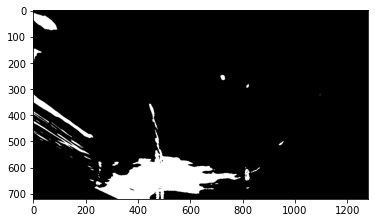

In [71]:
l_line = Line()
r_line = Line()
#my_clip.write_gif('test.gif', fps=12)
output = 'harder_challenge_video_output.mp4'
inputVid = VideoFileClip('harder_challenge_video.mp4')
processed_video = inputVid.fl_image(main)
%time processed_video.write_videofile(output, audio=False)